# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # DONE : Implement function and return a dataloader
    
    # image processing
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()
                                   ])
    
    # dataset of images
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    # dataloader of images
    dataloader = torch.utils.data.DataLoader( dataset = dataset,
                                              batch_size = batch_size,
                                              shuffle = True,
                                              num_workers = 0)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size   = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

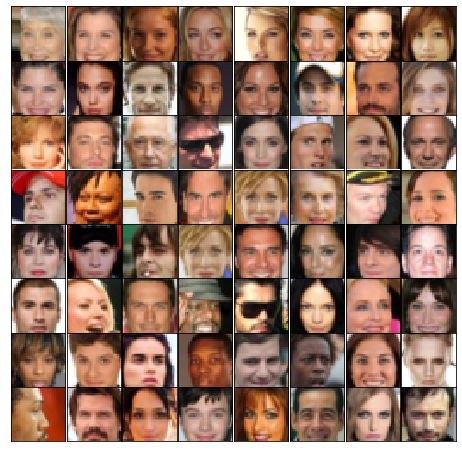

In [7]:
# I want to see another larger sample of training images

fig = plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)
plot_size=64
for idx in np.arange(plot_size):
    ax = fig.add_subplot(8, plot_size/8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# DONE : Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
        with a feature_range of pixel values from -1 to 1. 
        This function assumes that the input x is already scaled from 0-1.
    '''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x

    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.8667)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    '''
        Creates a convolutional layer with optional batch normalization
    '''

    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)


In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.alpha    = 0.2
        self.conv_dim = conv_dim
        
        # convolutional layers
        self.conv1    = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2    = conv(conv_dim, conv_dim*2, 4)
        self.conv3    = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4    = conv(conv_dim*4, conv_dim*8, 4)
        
        # final fully connected layer
        self.fc       = nn.Linear( conv_dim*8*2*2, 1 )

        # dropout layer
        self.dropout  = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.leaky_relu(self.conv1(x), self.alpha)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x), self.alpha)
        x = F.leaky_relu(self.conv3(x), self.alpha)
        x = F.leaky_relu(self.conv4(x), self.alpha)
        x = self.dropout(x)
        
        # flatten
        x = x.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    '''
        Creates a transposed-convolutional layer with optional batch normalization
    '''
    
    layers = []
    
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first fully connected layer
        self.fc       = nn.Linear(z_size, conv_dim*8*2*2)
        
        # transpose convolutional layers
        self.t_conv1  = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2  = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3  = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4  = deconv(conv_dim, 3, 4, batch_norm=False)

        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2) 
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.tanh(self.t_conv4(x))

        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # DONE : Apply initial weights to convolutional and linear layers

    mean   = 0
    stddev = 0.02
    bias   = 0
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        
        m.weight.data.normal_(mean, stddev)
        #m.bias.data.fill_(bias)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams

d_conv_dim = 64
g_conv_dim = 64
z_size     = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=False):
    '''
       Calculates how close discriminator outputs are to being real.
       param, D_out  : discriminator logits
       param, smooth : apply smoothing to real labels
       return: real loss
    '''
    
    batch_size = D_out.size(0)
    
    # real labels are Ones with optional smoothing from 0.7 to 1.0
    if smooth:
        labels = torch.ones(batch_size) * (1-np.random.random()*0.3)
    else:
        labels = torch.ones(batch_size)
        
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out, smooth=False):
    '''
       Calculates how close discriminator outputs are to being fake.
       param, D_out : discriminator logits
       return: fake loss
    '''
    
    batch_size = D_out.size(0)
    
    # real labels are Zeros with optional smoothing from 0.0 to 0.3
    if smooth:
        labels = torch.ones(batch_size) * (np.random.random()*0.3)
    else:
        labels = torch.zeros(batch_size)
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# Optimizer parameters

lr    = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator and generator

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''
       Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses
    '''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
        
            if train_on_gpu:
                real_images = real_images.cuda()
        
            # compute discriminator loss on real images            
            d_real = D(real_images)
            d_real_loss = real_loss(d_real, smooth=True)
        
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
        
            # compute discriminator loss on fake images            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
        
            # add up loss and backprop 
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
        
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
        
            # compute discriminator loss on fake images - use real loss to flip labels
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake, smooth=True)
        
            # backprop 
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()
        
        # show sample images each epoch
        fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples_z):
            img = img.detach().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = ((img + 1)*255 / (2)).astype(np.uint8)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((32,32,3)))
        plt.show()
        

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/   50] | d_loss: 1.5460 | g_loss: 1.8270
Epoch [    1/   50] | d_loss: 0.6237 | g_loss: 3.3035
Epoch [    1/   50] | d_loss: 0.9888 | g_loss: 3.0460
Epoch [    1/   50] | d_loss: 1.2811 | g_loss: 3.3928
Epoch [    1/   50] | d_loss: 0.9755 | g_loss: 2.0113
Epoch [    1/   50] | d_loss: 1.1282 | g_loss: 3.1963
Epoch [    1/   50] | d_loss: 0.7751 | g_loss: 2.2492
Epoch [    1/   50] | d_loss: 0.7735 | g_loss: 2.2941
Epoch [    1/   50] | d_loss: 0.8624 | g_loss: 2.9287
Epoch [    1/   50] | d_loss: 1.1210 | g_loss: 2.4853
Epoch [    1/   50] | d_loss: 0.8675 | g_loss: 2.8385
Epoch [    1/   50] | d_loss: 1.1616 | g_loss: 2.1816
Epoch [    1/   50] | d_loss: 0.7828 | g_loss: 4.8364
Epoch [    1/   50] | d_loss: 0.9136 | g_loss: 3.1321
Epoch [    1/   50] | d_loss: 1.0027 | g_loss: 2.8012
Epoch [    1/   50] | d_loss: 1.0084 | g_loss: 2.9936
Epoch [    1/   50] | d_loss: 0.9266 | g_loss: 1.6754
Epoch [    1/   50] | d_loss: 0.7455 | g_loss: 1.7051
Epoch [    1/   50] | d_loss

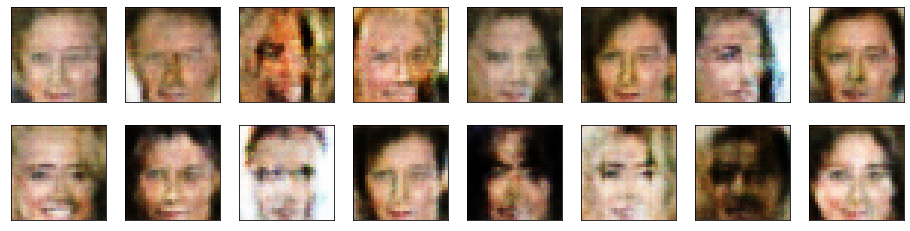

Epoch [    2/   50] | d_loss: 0.9781 | g_loss: 2.6993
Epoch [    2/   50] | d_loss: 0.6486 | g_loss: 2.5665
Epoch [    2/   50] | d_loss: 0.9116 | g_loss: 2.5881
Epoch [    2/   50] | d_loss: 0.9571 | g_loss: 2.1619
Epoch [    2/   50] | d_loss: 1.1522 | g_loss: 2.0017
Epoch [    2/   50] | d_loss: 1.0332 | g_loss: 2.2480
Epoch [    2/   50] | d_loss: 0.8331 | g_loss: 2.3011
Epoch [    2/   50] | d_loss: 0.9055 | g_loss: 2.0942
Epoch [    2/   50] | d_loss: 0.9186 | g_loss: 1.6383
Epoch [    2/   50] | d_loss: 1.1155 | g_loss: 2.1444
Epoch [    2/   50] | d_loss: 0.8862 | g_loss: 2.6539
Epoch [    2/   50] | d_loss: 0.7781 | g_loss: 2.1022
Epoch [    2/   50] | d_loss: 1.0837 | g_loss: 2.8279
Epoch [    2/   50] | d_loss: 1.0116 | g_loss: 2.1263
Epoch [    2/   50] | d_loss: 0.9470 | g_loss: 2.0567
Epoch [    2/   50] | d_loss: 1.4414 | g_loss: 1.1462
Epoch [    2/   50] | d_loss: 0.9868 | g_loss: 2.1256
Epoch [    2/   50] | d_loss: 1.1909 | g_loss: 2.7110
Epoch [    2/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.1681 | g_loss: 2.7095
Epoch [    3/   50] | d_loss: 0.8842 | g_loss: 2.0172
Epoch [    3/   50] | d_loss: 0.9110 | g_loss: 1.8327
Epoch [    3/   50] | d_loss: 1.1049 | g_loss: 1.9576
Epoch [    3/   50] | d_loss: 0.9239 | g_loss: 2.1295
Epoch [    3/   50] | d_loss: 1.1322 | g_loss: 1.3734
Epoch [    3/   50] | d_loss: 0.8699 | g_loss: 2.6478
Epoch [    3/   50] | d_loss: 0.8488 | g_loss: 1.8470
Epoch [    3/   50] | d_loss: 1.2822 | g_loss: 1.1182
Epoch [    3/   50] | d_loss: 1.0703 | g_loss: 1.5323
Epoch [    3/   50] | d_loss: 0.7086 | g_loss: 1.1117
Epoch [    3/   50] | d_loss: 0.9727 | g_loss: 2.0048
Epoch [    3/   50] | d_loss: 0.8784 | g_loss: 1.5370
Epoch [    3/   50] | d_loss: 1.2147 | g_loss: 2.6253
Epoch [    3/   50] | d_loss: 1.1571 | g_loss: 1.8911
Epoch [    3/   50] | d_loss: 0.9425 | g_loss: 2.3368
Epoch [    3/   50] | d_loss: 1.2511 | g_loss: 1.3595
Epoch [    3/   50] | d_loss: 1.0613 | g_loss: 1.6678
Epoch [    3/   50] | d_loss

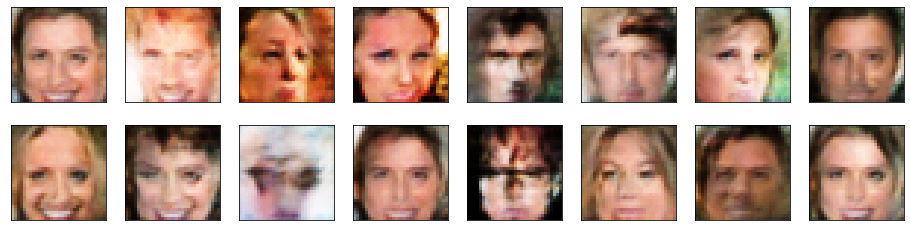

Epoch [    4/   50] | d_loss: 1.1046 | g_loss: 1.7986
Epoch [    4/   50] | d_loss: 1.2761 | g_loss: 3.5738
Epoch [    4/   50] | d_loss: 1.2637 | g_loss: 1.7896
Epoch [    4/   50] | d_loss: 0.9899 | g_loss: 1.5802
Epoch [    4/   50] | d_loss: 1.0306 | g_loss: 1.3622
Epoch [    4/   50] | d_loss: 1.1911 | g_loss: 1.5623
Epoch [    4/   50] | d_loss: 0.9249 | g_loss: 1.1096
Epoch [    4/   50] | d_loss: 1.0012 | g_loss: 1.1956
Epoch [    4/   50] | d_loss: 1.0319 | g_loss: 1.8528
Epoch [    4/   50] | d_loss: 1.0215 | g_loss: 1.8627
Epoch [    4/   50] | d_loss: 0.9832 | g_loss: 1.6411
Epoch [    4/   50] | d_loss: 1.0019 | g_loss: 2.0044
Epoch [    4/   50] | d_loss: 0.9570 | g_loss: 1.6599
Epoch [    4/   50] | d_loss: 0.9638 | g_loss: 1.6140
Epoch [    4/   50] | d_loss: 1.1012 | g_loss: 1.2750
Epoch [    4/   50] | d_loss: 1.0414 | g_loss: 1.4222
Epoch [    4/   50] | d_loss: 1.1013 | g_loss: 1.7297
Epoch [    4/   50] | d_loss: 0.9777 | g_loss: 1.1950
Epoch [    4/   50] | d_loss

Epoch [    5/   50] | d_loss: 1.0992 | g_loss: 1.4983
Epoch [    5/   50] | d_loss: 1.2341 | g_loss: 1.1983
Epoch [    5/   50] | d_loss: 1.0232 | g_loss: 1.3823
Epoch [    5/   50] | d_loss: 0.7822 | g_loss: 1.1522
Epoch [    5/   50] | d_loss: 1.3058 | g_loss: 0.9904
Epoch [    5/   50] | d_loss: 0.9599 | g_loss: 1.3025
Epoch [    5/   50] | d_loss: 1.2095 | g_loss: 1.0954
Epoch [    5/   50] | d_loss: 1.1576 | g_loss: 1.4360
Epoch [    5/   50] | d_loss: 1.0084 | g_loss: 1.6736
Epoch [    5/   50] | d_loss: 1.0073 | g_loss: 1.2141
Epoch [    5/   50] | d_loss: 1.0492 | g_loss: 1.0093
Epoch [    5/   50] | d_loss: 1.1882 | g_loss: 1.1056
Epoch [    5/   50] | d_loss: 1.1611 | g_loss: 1.2621
Epoch [    5/   50] | d_loss: 1.0148 | g_loss: 1.4902
Epoch [    5/   50] | d_loss: 1.1978 | g_loss: 1.8259
Epoch [    5/   50] | d_loss: 1.1126 | g_loss: 1.4131
Epoch [    5/   50] | d_loss: 1.3255 | g_loss: 2.2731
Epoch [    5/   50] | d_loss: 1.2169 | g_loss: 1.5357
Epoch [    5/   50] | d_loss

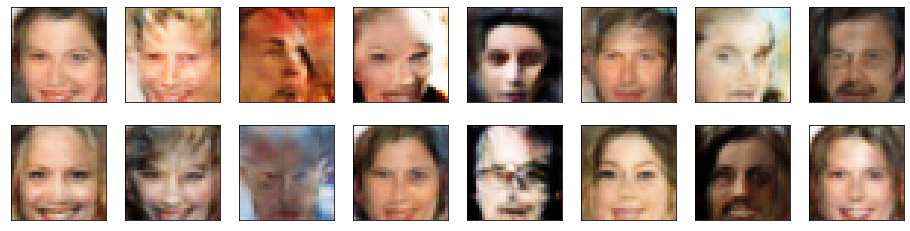

Epoch [    6/   50] | d_loss: 1.4410 | g_loss: 1.2541
Epoch [    6/   50] | d_loss: 1.3876 | g_loss: 2.4239
Epoch [    6/   50] | d_loss: 0.9515 | g_loss: 1.4471
Epoch [    6/   50] | d_loss: 0.9995 | g_loss: 2.3706
Epoch [    6/   50] | d_loss: 1.0016 | g_loss: 1.1247
Epoch [    6/   50] | d_loss: 1.2749 | g_loss: 1.0712
Epoch [    6/   50] | d_loss: 0.9888 | g_loss: 3.0317
Epoch [    6/   50] | d_loss: 1.2143 | g_loss: 1.1762
Epoch [    6/   50] | d_loss: 1.1514 | g_loss: 1.5223
Epoch [    6/   50] | d_loss: 0.9775 | g_loss: 2.1711
Epoch [    6/   50] | d_loss: 0.9417 | g_loss: 1.3918
Epoch [    6/   50] | d_loss: 1.0105 | g_loss: 1.6583
Epoch [    6/   50] | d_loss: 1.3051 | g_loss: 1.3822
Epoch [    6/   50] | d_loss: 1.2397 | g_loss: 1.5635
Epoch [    6/   50] | d_loss: 1.1737 | g_loss: 0.9590
Epoch [    6/   50] | d_loss: 1.0662 | g_loss: 1.2672
Epoch [    6/   50] | d_loss: 1.0543 | g_loss: 1.7044
Epoch [    6/   50] | d_loss: 0.9983 | g_loss: 1.4193
Epoch [    6/   50] | d_loss

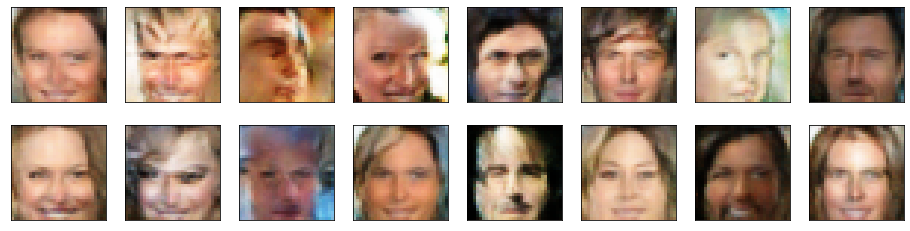

Epoch [    7/   50] | d_loss: 1.1649 | g_loss: 1.6633
Epoch [    7/   50] | d_loss: 0.9982 | g_loss: 1.2984
Epoch [    7/   50] | d_loss: 1.0594 | g_loss: 1.6275
Epoch [    7/   50] | d_loss: 0.9635 | g_loss: 2.0982
Epoch [    7/   50] | d_loss: 1.0714 | g_loss: 1.6151
Epoch [    7/   50] | d_loss: 1.0021 | g_loss: 1.6235
Epoch [    7/   50] | d_loss: 1.2300 | g_loss: 1.1370
Epoch [    7/   50] | d_loss: 1.0177 | g_loss: 1.3682
Epoch [    7/   50] | d_loss: 1.2862 | g_loss: 1.6430
Epoch [    7/   50] | d_loss: 0.8887 | g_loss: 1.5018
Epoch [    7/   50] | d_loss: 1.2008 | g_loss: 1.5084
Epoch [    7/   50] | d_loss: 1.0431 | g_loss: 1.5005
Epoch [    7/   50] | d_loss: 1.0328 | g_loss: 1.1409
Epoch [    7/   50] | d_loss: 1.0877 | g_loss: 1.0636
Epoch [    7/   50] | d_loss: 0.9750 | g_loss: 1.8061
Epoch [    7/   50] | d_loss: 1.1789 | g_loss: 1.6407
Epoch [    7/   50] | d_loss: 1.2417 | g_loss: 1.1177
Epoch [    7/   50] | d_loss: 1.0086 | g_loss: 1.2937
Epoch [    7/   50] | d_loss

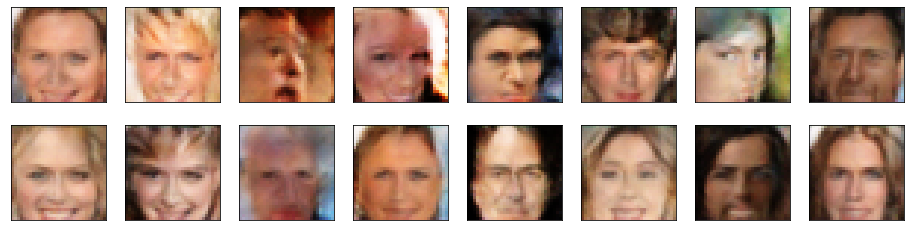

Epoch [    8/   50] | d_loss: 1.1617 | g_loss: 1.7307
Epoch [    8/   50] | d_loss: 1.0697 | g_loss: 0.9087
Epoch [    8/   50] | d_loss: 1.1314 | g_loss: 1.7769
Epoch [    8/   50] | d_loss: 1.1195 | g_loss: 1.1435
Epoch [    8/   50] | d_loss: 1.0553 | g_loss: 1.3934
Epoch [    8/   50] | d_loss: 0.9617 | g_loss: 2.0977
Epoch [    8/   50] | d_loss: 1.2028 | g_loss: 1.6502
Epoch [    8/   50] | d_loss: 1.1476 | g_loss: 2.0073
Epoch [    8/   50] | d_loss: 0.8922 | g_loss: 1.4286
Epoch [    8/   50] | d_loss: 0.8670 | g_loss: 1.2401
Epoch [    8/   50] | d_loss: 1.1378 | g_loss: 0.9897
Epoch [    8/   50] | d_loss: 0.8911 | g_loss: 1.0179
Epoch [    8/   50] | d_loss: 1.1676 | g_loss: 1.3818
Epoch [    8/   50] | d_loss: 0.9474 | g_loss: 1.2875
Epoch [    8/   50] | d_loss: 1.3486 | g_loss: 1.8245
Epoch [    8/   50] | d_loss: 1.2342 | g_loss: 1.1382
Epoch [    8/   50] | d_loss: 1.0882 | g_loss: 1.1024
Epoch [    8/   50] | d_loss: 1.0890 | g_loss: 1.4447
Epoch [    8/   50] | d_loss

Epoch [    9/   50] | d_loss: 1.8352 | g_loss: 1.7593
Epoch [    9/   50] | d_loss: 1.3050 | g_loss: 1.4155
Epoch [    9/   50] | d_loss: 1.2451 | g_loss: 1.3903
Epoch [    9/   50] | d_loss: 1.2442 | g_loss: 1.8244
Epoch [    9/   50] | d_loss: 1.0994 | g_loss: 0.9836
Epoch [    9/   50] | d_loss: 0.9849 | g_loss: 1.2764
Epoch [    9/   50] | d_loss: 0.8517 | g_loss: 1.4978
Epoch [    9/   50] | d_loss: 0.9780 | g_loss: 1.6578
Epoch [    9/   50] | d_loss: 0.8662 | g_loss: 1.1797
Epoch [    9/   50] | d_loss: 0.9705 | g_loss: 1.5529
Epoch [    9/   50] | d_loss: 1.0648 | g_loss: 1.2759
Epoch [    9/   50] | d_loss: 0.9182 | g_loss: 1.2592
Epoch [    9/   50] | d_loss: 1.1837 | g_loss: 1.2989
Epoch [    9/   50] | d_loss: 1.3433 | g_loss: 1.2078
Epoch [    9/   50] | d_loss: 1.0291 | g_loss: 1.8743
Epoch [    9/   50] | d_loss: 1.0376 | g_loss: 1.5769
Epoch [    9/   50] | d_loss: 0.9091 | g_loss: 1.4591
Epoch [    9/   50] | d_loss: 1.2632 | g_loss: 2.2671
Epoch [    9/   50] | d_loss

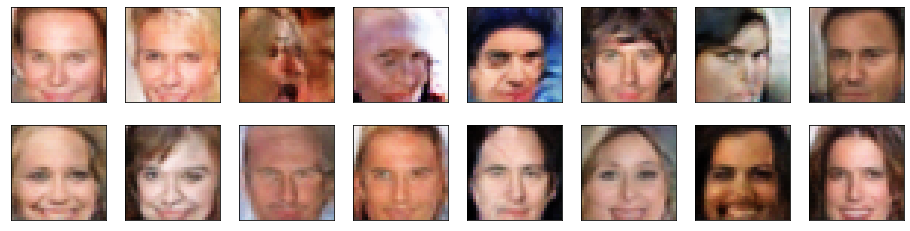

Epoch [   10/   50] | d_loss: 1.0486 | g_loss: 0.9349
Epoch [   10/   50] | d_loss: 0.9766 | g_loss: 1.2225
Epoch [   10/   50] | d_loss: 1.0796 | g_loss: 0.9446
Epoch [   10/   50] | d_loss: 1.0260 | g_loss: 1.4830
Epoch [   10/   50] | d_loss: 1.0840 | g_loss: 1.3903
Epoch [   10/   50] | d_loss: 0.9857 | g_loss: 1.9107
Epoch [   10/   50] | d_loss: 1.1669 | g_loss: 1.5714
Epoch [   10/   50] | d_loss: 1.0020 | g_loss: 1.7685
Epoch [   10/   50] | d_loss: 0.9928 | g_loss: 1.9863
Epoch [   10/   50] | d_loss: 0.7914 | g_loss: 0.9826
Epoch [   10/   50] | d_loss: 1.3305 | g_loss: 1.8781
Epoch [   10/   50] | d_loss: 1.1279 | g_loss: 1.1768
Epoch [   10/   50] | d_loss: 1.2584 | g_loss: 1.3681
Epoch [   10/   50] | d_loss: 1.0814 | g_loss: 1.4540
Epoch [   10/   50] | d_loss: 0.9338 | g_loss: 1.6997
Epoch [   10/   50] | d_loss: 1.1341 | g_loss: 1.6033
Epoch [   10/   50] | d_loss: 1.0742 | g_loss: 1.5450
Epoch [   10/   50] | d_loss: 1.1636 | g_loss: 2.0337
Epoch [   10/   50] | d_loss

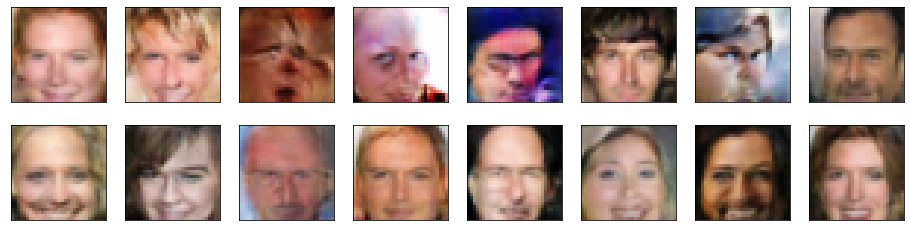

Epoch [   11/   50] | d_loss: 1.1848 | g_loss: 0.7664
Epoch [   11/   50] | d_loss: 0.9849 | g_loss: 1.5274
Epoch [   11/   50] | d_loss: 1.1001 | g_loss: 1.5559
Epoch [   11/   50] | d_loss: 1.0798 | g_loss: 1.1698
Epoch [   11/   50] | d_loss: 1.2450 | g_loss: 1.1725
Epoch [   11/   50] | d_loss: 0.8753 | g_loss: 1.5364
Epoch [   11/   50] | d_loss: 1.0338 | g_loss: 1.9518
Epoch [   11/   50] | d_loss: 1.0385 | g_loss: 1.3727
Epoch [   11/   50] | d_loss: 0.9092 | g_loss: 2.0590
Epoch [   11/   50] | d_loss: 1.0576 | g_loss: 1.3304
Epoch [   11/   50] | d_loss: 1.2173 | g_loss: 1.3771
Epoch [   11/   50] | d_loss: 1.2989 | g_loss: 2.0274
Epoch [   11/   50] | d_loss: 0.9508 | g_loss: 1.7631
Epoch [   11/   50] | d_loss: 0.9888 | g_loss: 2.0739
Epoch [   11/   50] | d_loss: 1.1258 | g_loss: 1.3163
Epoch [   11/   50] | d_loss: 0.8579 | g_loss: 1.5046
Epoch [   11/   50] | d_loss: 1.2573 | g_loss: 1.7492
Epoch [   11/   50] | d_loss: 1.1542 | g_loss: 1.2445
Epoch [   11/   50] | d_loss

Epoch [   12/   50] | d_loss: 1.2916 | g_loss: 1.7289
Epoch [   12/   50] | d_loss: 1.1921 | g_loss: 1.0393
Epoch [   12/   50] | d_loss: 1.0121 | g_loss: 1.5817
Epoch [   12/   50] | d_loss: 1.0110 | g_loss: 1.8049
Epoch [   12/   50] | d_loss: 0.9336 | g_loss: 1.4195
Epoch [   12/   50] | d_loss: 1.5572 | g_loss: 1.4754
Epoch [   12/   50] | d_loss: 1.2251 | g_loss: 1.7516
Epoch [   12/   50] | d_loss: 0.9760 | g_loss: 1.6641
Epoch [   12/   50] | d_loss: 1.4360 | g_loss: 1.7853
Epoch [   12/   50] | d_loss: 1.1122 | g_loss: 1.4350
Epoch [   12/   50] | d_loss: 1.1138 | g_loss: 2.2111
Epoch [   12/   50] | d_loss: 1.3170 | g_loss: 0.8526
Epoch [   12/   50] | d_loss: 1.0667 | g_loss: 1.4465
Epoch [   12/   50] | d_loss: 1.2036 | g_loss: 1.1646
Epoch [   12/   50] | d_loss: 1.0173 | g_loss: 1.8294
Epoch [   12/   50] | d_loss: 0.9889 | g_loss: 1.8616
Epoch [   12/   50] | d_loss: 1.0423 | g_loss: 1.2988
Epoch [   12/   50] | d_loss: 0.7957 | g_loss: 1.9617
Epoch [   12/   50] | d_loss

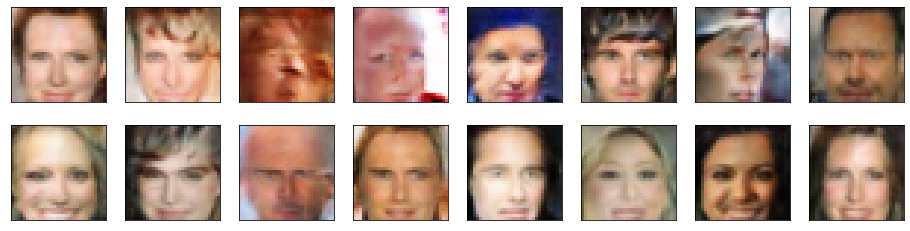

Epoch [   13/   50] | d_loss: 1.5009 | g_loss: 2.1346
Epoch [   13/   50] | d_loss: 1.0352 | g_loss: 1.8825
Epoch [   13/   50] | d_loss: 1.0307 | g_loss: 1.5998
Epoch [   13/   50] | d_loss: 1.1202 | g_loss: 1.2344
Epoch [   13/   50] | d_loss: 1.3228 | g_loss: 1.8190
Epoch [   13/   50] | d_loss: 0.9260 | g_loss: 1.4302
Epoch [   13/   50] | d_loss: 1.0892 | g_loss: 0.9929
Epoch [   13/   50] | d_loss: 1.2055 | g_loss: 1.2404
Epoch [   13/   50] | d_loss: 1.5248 | g_loss: 2.5361
Epoch [   13/   50] | d_loss: 1.0913 | g_loss: 1.4431
Epoch [   13/   50] | d_loss: 1.2122 | g_loss: 1.5371
Epoch [   13/   50] | d_loss: 1.3009 | g_loss: 1.7221
Epoch [   13/   50] | d_loss: 0.9646 | g_loss: 0.9678
Epoch [   13/   50] | d_loss: 0.8925 | g_loss: 2.0705
Epoch [   13/   50] | d_loss: 1.0033 | g_loss: 1.0587
Epoch [   13/   50] | d_loss: 1.2354 | g_loss: 1.8067
Epoch [   13/   50] | d_loss: 0.7863 | g_loss: 1.2255
Epoch [   13/   50] | d_loss: 1.0222 | g_loss: 1.9807
Epoch [   13/   50] | d_loss

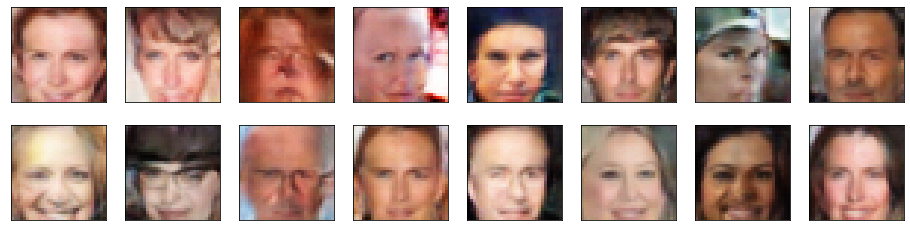

Epoch [   14/   50] | d_loss: 0.9927 | g_loss: 1.4464
Epoch [   14/   50] | d_loss: 0.9778 | g_loss: 1.8412
Epoch [   14/   50] | d_loss: 1.1991 | g_loss: 1.6631
Epoch [   14/   50] | d_loss: 1.0356 | g_loss: 1.4428
Epoch [   14/   50] | d_loss: 1.0592 | g_loss: 1.2841
Epoch [   14/   50] | d_loss: 0.9427 | g_loss: 1.5979
Epoch [   14/   50] | d_loss: 0.8914 | g_loss: 1.2234
Epoch [   14/   50] | d_loss: 0.9915 | g_loss: 1.3798
Epoch [   14/   50] | d_loss: 0.9325 | g_loss: 2.4422
Epoch [   14/   50] | d_loss: 1.1467 | g_loss: 2.1822
Epoch [   14/   50] | d_loss: 0.9682 | g_loss: 1.1466
Epoch [   14/   50] | d_loss: 1.0551 | g_loss: 1.0797
Epoch [   14/   50] | d_loss: 1.3010 | g_loss: 0.9694
Epoch [   14/   50] | d_loss: 1.1596 | g_loss: 1.3865
Epoch [   14/   50] | d_loss: 1.0326 | g_loss: 1.3590
Epoch [   14/   50] | d_loss: 0.8244 | g_loss: 2.3585
Epoch [   14/   50] | d_loss: 1.0531 | g_loss: 2.4149
Epoch [   14/   50] | d_loss: 1.1232 | g_loss: 1.8392
Epoch [   14/   50] | d_loss

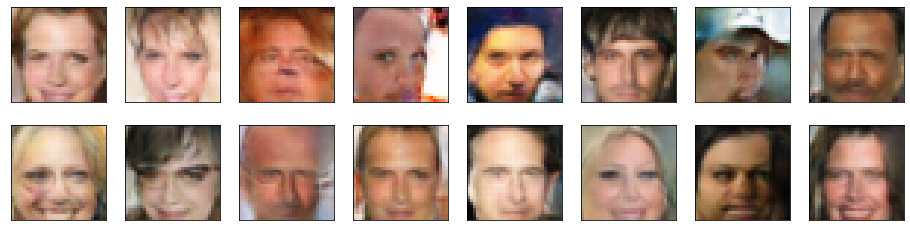

Epoch [   15/   50] | d_loss: 1.1117 | g_loss: 1.2261
Epoch [   15/   50] | d_loss: 0.9807 | g_loss: 1.1053
Epoch [   15/   50] | d_loss: 1.0978 | g_loss: 2.0706
Epoch [   15/   50] | d_loss: 0.7637 | g_loss: 0.9374
Epoch [   15/   50] | d_loss: 0.6644 | g_loss: 1.2900
Epoch [   15/   50] | d_loss: 1.0303 | g_loss: 1.7085
Epoch [   15/   50] | d_loss: 0.9414 | g_loss: 1.8797
Epoch [   15/   50] | d_loss: 0.9887 | g_loss: 2.4845
Epoch [   15/   50] | d_loss: 0.7895 | g_loss: 1.7831
Epoch [   15/   50] | d_loss: 0.8073 | g_loss: 2.0577
Epoch [   15/   50] | d_loss: 0.8748 | g_loss: 1.5031
Epoch [   15/   50] | d_loss: 1.2012 | g_loss: 2.0633
Epoch [   15/   50] | d_loss: 0.9468 | g_loss: 1.2984
Epoch [   15/   50] | d_loss: 1.0314 | g_loss: 1.4763
Epoch [   15/   50] | d_loss: 0.9787 | g_loss: 1.8073
Epoch [   15/   50] | d_loss: 0.9680 | g_loss: 2.0422
Epoch [   15/   50] | d_loss: 1.1841 | g_loss: 1.3340
Epoch [   15/   50] | d_loss: 1.1947 | g_loss: 2.3520
Epoch [   15/   50] | d_loss

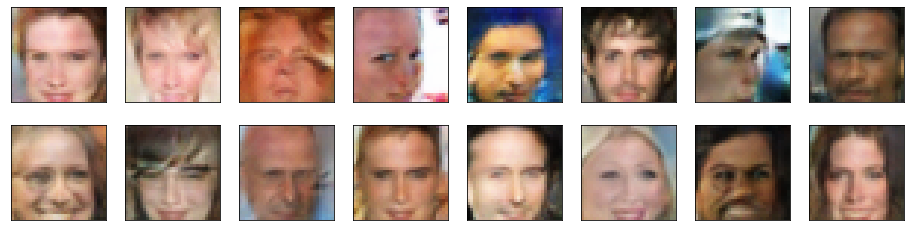

Epoch [   16/   50] | d_loss: 0.8466 | g_loss: 1.5070
Epoch [   16/   50] | d_loss: 0.7856 | g_loss: 1.7922
Epoch [   16/   50] | d_loss: 0.9979 | g_loss: 1.0306
Epoch [   16/   50] | d_loss: 1.0708 | g_loss: 1.7059
Epoch [   16/   50] | d_loss: 1.1084 | g_loss: 1.8472
Epoch [   16/   50] | d_loss: 1.2188 | g_loss: 1.2856
Epoch [   16/   50] | d_loss: 1.0427 | g_loss: 2.0636
Epoch [   16/   50] | d_loss: 1.3595 | g_loss: 2.3559
Epoch [   16/   50] | d_loss: 1.1079 | g_loss: 1.9942
Epoch [   16/   50] | d_loss: 1.0782 | g_loss: 0.8999
Epoch [   16/   50] | d_loss: 1.1255 | g_loss: 2.4863
Epoch [   16/   50] | d_loss: 1.1072 | g_loss: 1.6738
Epoch [   16/   50] | d_loss: 1.1160 | g_loss: 1.0037
Epoch [   16/   50] | d_loss: 1.1714 | g_loss: 1.7048
Epoch [   16/   50] | d_loss: 0.8766 | g_loss: 1.3886
Epoch [   16/   50] | d_loss: 1.0110 | g_loss: 1.4265
Epoch [   16/   50] | d_loss: 0.8793 | g_loss: 1.7477
Epoch [   16/   50] | d_loss: 0.8683 | g_loss: 2.1257
Epoch [   16/   50] | d_loss

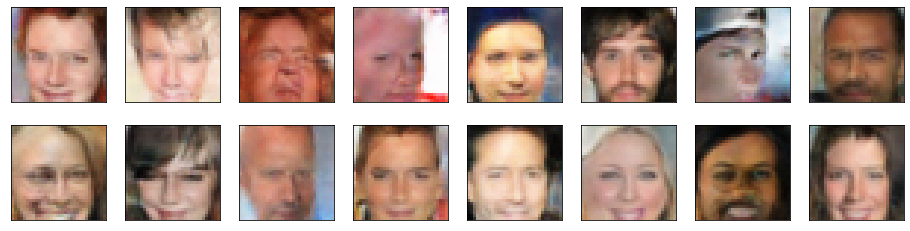

Epoch [   17/   50] | d_loss: 0.9338 | g_loss: 1.6275
Epoch [   17/   50] | d_loss: 0.8708 | g_loss: 1.7694
Epoch [   17/   50] | d_loss: 0.7936 | g_loss: 1.5342
Epoch [   17/   50] | d_loss: 0.7340 | g_loss: 1.4382
Epoch [   17/   50] | d_loss: 0.8716 | g_loss: 2.7222
Epoch [   17/   50] | d_loss: 0.7040 | g_loss: 1.7675
Epoch [   17/   50] | d_loss: 1.0155 | g_loss: 1.3113
Epoch [   17/   50] | d_loss: 0.6382 | g_loss: 2.0059
Epoch [   17/   50] | d_loss: 0.9359 | g_loss: 1.9178
Epoch [   17/   50] | d_loss: 1.1112 | g_loss: 1.7324
Epoch [   17/   50] | d_loss: 1.0786 | g_loss: 1.7141
Epoch [   17/   50] | d_loss: 1.1046 | g_loss: 1.2573
Epoch [   17/   50] | d_loss: 0.9502 | g_loss: 1.8886
Epoch [   17/   50] | d_loss: 1.1346 | g_loss: 1.7462
Epoch [   17/   50] | d_loss: 1.0602 | g_loss: 1.2200
Epoch [   17/   50] | d_loss: 1.0724 | g_loss: 2.3637
Epoch [   17/   50] | d_loss: 1.2418 | g_loss: 1.9037
Epoch [   17/   50] | d_loss: 0.9948 | g_loss: 1.0143
Epoch [   17/   50] | d_loss

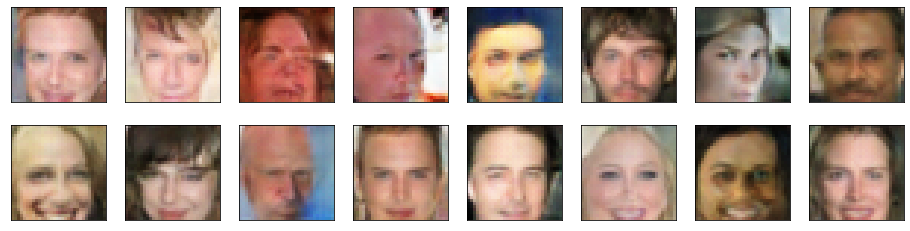

Epoch [   18/   50] | d_loss: 1.0674 | g_loss: 2.0279
Epoch [   18/   50] | d_loss: 1.2226 | g_loss: 2.4553
Epoch [   18/   50] | d_loss: 1.1812 | g_loss: 1.5638
Epoch [   18/   50] | d_loss: 0.8913 | g_loss: 1.6284
Epoch [   18/   50] | d_loss: 0.9958 | g_loss: 1.5612
Epoch [   18/   50] | d_loss: 0.9116 | g_loss: 1.3233
Epoch [   18/   50] | d_loss: 0.9458 | g_loss: 1.5584
Epoch [   18/   50] | d_loss: 1.0205 | g_loss: 1.3910
Epoch [   18/   50] | d_loss: 1.1954 | g_loss: 2.1832
Epoch [   18/   50] | d_loss: 0.9388 | g_loss: 1.5697
Epoch [   18/   50] | d_loss: 0.9003 | g_loss: 2.0069
Epoch [   18/   50] | d_loss: 0.9377 | g_loss: 1.3502
Epoch [   18/   50] | d_loss: 1.2809 | g_loss: 2.2179
Epoch [   18/   50] | d_loss: 1.0307 | g_loss: 2.2213
Epoch [   18/   50] | d_loss: 1.0309 | g_loss: 2.2859
Epoch [   18/   50] | d_loss: 0.8625 | g_loss: 0.9749
Epoch [   18/   50] | d_loss: 1.1659 | g_loss: 1.7093
Epoch [   18/   50] | d_loss: 0.9806 | g_loss: 1.8890
Epoch [   18/   50] | d_loss

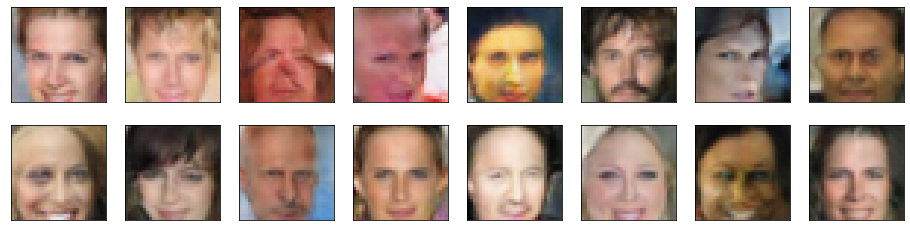

Epoch [   19/   50] | d_loss: 1.0659 | g_loss: 1.3862
Epoch [   19/   50] | d_loss: 0.7680 | g_loss: 2.2309
Epoch [   19/   50] | d_loss: 0.8392 | g_loss: 1.5569
Epoch [   19/   50] | d_loss: 1.0179 | g_loss: 2.0022
Epoch [   19/   50] | d_loss: 1.2259 | g_loss: 1.1651
Epoch [   19/   50] | d_loss: 0.9179 | g_loss: 1.2378
Epoch [   19/   50] | d_loss: 0.7877 | g_loss: 2.5032
Epoch [   19/   50] | d_loss: 1.0454 | g_loss: 1.9295
Epoch [   19/   50] | d_loss: 1.0024 | g_loss: 2.0427
Epoch [   19/   50] | d_loss: 1.0320 | g_loss: 2.6324
Epoch [   19/   50] | d_loss: 1.0063 | g_loss: 1.4810
Epoch [   19/   50] | d_loss: 0.8729 | g_loss: 1.9712
Epoch [   19/   50] | d_loss: 0.9980 | g_loss: 1.2164
Epoch [   19/   50] | d_loss: 0.9596 | g_loss: 2.5205
Epoch [   19/   50] | d_loss: 0.7931 | g_loss: 1.3470
Epoch [   19/   50] | d_loss: 0.9529 | g_loss: 2.1407
Epoch [   19/   50] | d_loss: 0.9814 | g_loss: 1.9293
Epoch [   19/   50] | d_loss: 0.9827 | g_loss: 0.8914
Epoch [   19/   50] | d_loss

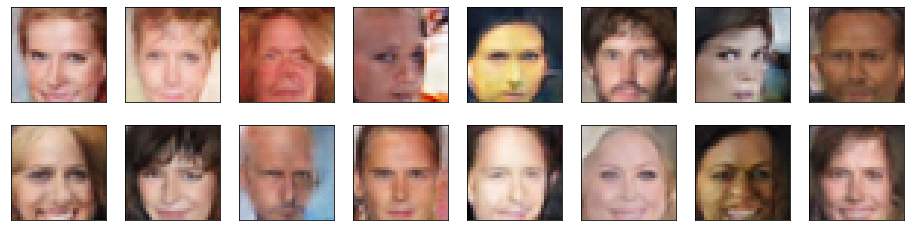

Epoch [   20/   50] | d_loss: 1.1699 | g_loss: 1.8900
Epoch [   20/   50] | d_loss: 1.1427 | g_loss: 1.2516
Epoch [   20/   50] | d_loss: 0.9742 | g_loss: 2.2197
Epoch [   20/   50] | d_loss: 1.0827 | g_loss: 1.0800
Epoch [   20/   50] | d_loss: 0.9207 | g_loss: 2.2899
Epoch [   20/   50] | d_loss: 0.9872 | g_loss: 1.6691
Epoch [   20/   50] | d_loss: 1.0942 | g_loss: 1.1630
Epoch [   20/   50] | d_loss: 0.9890 | g_loss: 1.6036
Epoch [   20/   50] | d_loss: 0.9454 | g_loss: 0.9959
Epoch [   20/   50] | d_loss: 0.9775 | g_loss: 3.2269
Epoch [   20/   50] | d_loss: 0.9570 | g_loss: 1.7466
Epoch [   20/   50] | d_loss: 1.0159 | g_loss: 1.6941
Epoch [   20/   50] | d_loss: 0.7268 | g_loss: 1.6899
Epoch [   20/   50] | d_loss: 0.8407 | g_loss: 1.0923
Epoch [   20/   50] | d_loss: 1.0530 | g_loss: 1.7713
Epoch [   20/   50] | d_loss: 1.0283 | g_loss: 1.5869
Epoch [   20/   50] | d_loss: 0.9866 | g_loss: 1.8075
Epoch [   20/   50] | d_loss: 0.7732 | g_loss: 1.6278
Epoch [   20/   50] | d_loss

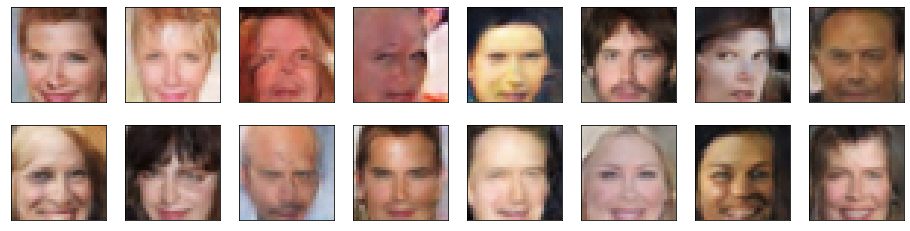

Epoch [   21/   50] | d_loss: 1.1139 | g_loss: 1.9902
Epoch [   21/   50] | d_loss: 1.0435 | g_loss: 1.4373
Epoch [   21/   50] | d_loss: 1.0686 | g_loss: 1.8212
Epoch [   21/   50] | d_loss: 1.1406 | g_loss: 1.3126
Epoch [   21/   50] | d_loss: 0.8521 | g_loss: 2.0055
Epoch [   21/   50] | d_loss: 0.7889 | g_loss: 1.9470
Epoch [   21/   50] | d_loss: 1.0053 | g_loss: 1.3555
Epoch [   21/   50] | d_loss: 0.6512 | g_loss: 1.6006
Epoch [   21/   50] | d_loss: 0.5863 | g_loss: 2.0216
Epoch [   21/   50] | d_loss: 0.9228 | g_loss: 1.8382
Epoch [   21/   50] | d_loss: 0.9727 | g_loss: 2.1898
Epoch [   21/   50] | d_loss: 0.9163 | g_loss: 1.5850
Epoch [   21/   50] | d_loss: 1.1103 | g_loss: 2.0891
Epoch [   21/   50] | d_loss: 0.9227 | g_loss: 2.1205
Epoch [   21/   50] | d_loss: 0.9022 | g_loss: 2.8616
Epoch [   21/   50] | d_loss: 1.0092 | g_loss: 1.3828
Epoch [   21/   50] | d_loss: 1.0000 | g_loss: 2.3504
Epoch [   21/   50] | d_loss: 0.6105 | g_loss: 1.7655
Epoch [   21/   50] | d_loss

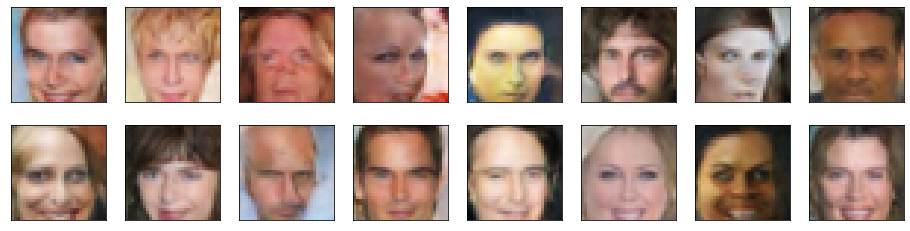

Epoch [   22/   50] | d_loss: 0.8577 | g_loss: 1.6921
Epoch [   22/   50] | d_loss: 0.9470 | g_loss: 2.0716
Epoch [   22/   50] | d_loss: 0.8702 | g_loss: 1.5283
Epoch [   22/   50] | d_loss: 0.8993 | g_loss: 2.1581
Epoch [   22/   50] | d_loss: 0.8209 | g_loss: 1.2565
Epoch [   22/   50] | d_loss: 1.0048 | g_loss: 2.5096
Epoch [   22/   50] | d_loss: 0.9728 | g_loss: 2.2605
Epoch [   22/   50] | d_loss: 0.8658 | g_loss: 1.4501
Epoch [   22/   50] | d_loss: 1.0763 | g_loss: 1.1049
Epoch [   22/   50] | d_loss: 0.8976 | g_loss: 1.9253
Epoch [   22/   50] | d_loss: 0.8421 | g_loss: 1.7946
Epoch [   22/   50] | d_loss: 0.8850 | g_loss: 1.1313
Epoch [   22/   50] | d_loss: 0.7293 | g_loss: 1.1668
Epoch [   22/   50] | d_loss: 0.7699 | g_loss: 1.2134
Epoch [   22/   50] | d_loss: 0.9343 | g_loss: 2.5828
Epoch [   22/   50] | d_loss: 0.8688 | g_loss: 2.7095
Epoch [   22/   50] | d_loss: 1.2799 | g_loss: 0.9207
Epoch [   22/   50] | d_loss: 0.8731 | g_loss: 1.3266
Epoch [   22/   50] | d_loss

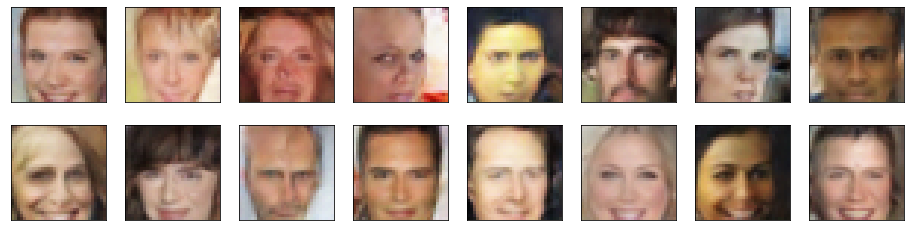

Epoch [   23/   50] | d_loss: 1.1200 | g_loss: 2.4398
Epoch [   23/   50] | d_loss: 0.7642 | g_loss: 1.3380
Epoch [   23/   50] | d_loss: 0.8688 | g_loss: 1.0354
Epoch [   23/   50] | d_loss: 0.9246 | g_loss: 3.2467
Epoch [   23/   50] | d_loss: 1.0302 | g_loss: 2.2007
Epoch [   23/   50] | d_loss: 0.9544 | g_loss: 1.9842
Epoch [   23/   50] | d_loss: 0.8263 | g_loss: 2.0134
Epoch [   23/   50] | d_loss: 1.1556 | g_loss: 1.9838
Epoch [   23/   50] | d_loss: 1.7729 | g_loss: 2.4914
Epoch [   23/   50] | d_loss: 0.9114 | g_loss: 1.6228
Epoch [   23/   50] | d_loss: 1.1224 | g_loss: 1.8554
Epoch [   23/   50] | d_loss: 0.8080 | g_loss: 1.0613
Epoch [   23/   50] | d_loss: 1.0900 | g_loss: 1.3683
Epoch [   23/   50] | d_loss: 0.7588 | g_loss: 1.3097
Epoch [   23/   50] | d_loss: 0.7973 | g_loss: 1.7028
Epoch [   23/   50] | d_loss: 0.9185 | g_loss: 2.4106
Epoch [   23/   50] | d_loss: 0.8917 | g_loss: 1.4375
Epoch [   23/   50] | d_loss: 0.8850 | g_loss: 1.5539
Epoch [   23/   50] | d_loss

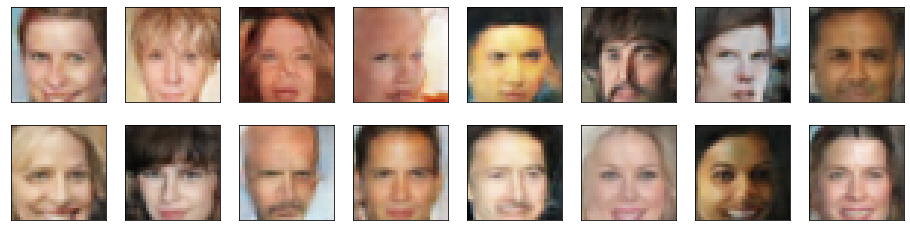

Epoch [   24/   50] | d_loss: 1.2891 | g_loss: 2.7952
Epoch [   24/   50] | d_loss: 0.8494 | g_loss: 1.4832
Epoch [   24/   50] | d_loss: 1.0084 | g_loss: 1.9061
Epoch [   24/   50] | d_loss: 1.0680 | g_loss: 2.0421
Epoch [   24/   50] | d_loss: 0.7949 | g_loss: 2.3142
Epoch [   24/   50] | d_loss: 0.8313 | g_loss: 2.0398
Epoch [   24/   50] | d_loss: 1.0915 | g_loss: 1.7226
Epoch [   24/   50] | d_loss: 0.8659 | g_loss: 2.4139
Epoch [   24/   50] | d_loss: 0.7944 | g_loss: 1.3891
Epoch [   24/   50] | d_loss: 0.8432 | g_loss: 1.3167
Epoch [   24/   50] | d_loss: 0.8678 | g_loss: 1.1394
Epoch [   24/   50] | d_loss: 0.8257 | g_loss: 2.6388
Epoch [   24/   50] | d_loss: 0.8413 | g_loss: 1.9028
Epoch [   24/   50] | d_loss: 1.0063 | g_loss: 2.0872
Epoch [   24/   50] | d_loss: 1.0412 | g_loss: 1.5179
Epoch [   24/   50] | d_loss: 0.9523 | g_loss: 2.3139
Epoch [   24/   50] | d_loss: 0.8229 | g_loss: 2.3101
Epoch [   24/   50] | d_loss: 1.5532 | g_loss: 1.4116
Epoch [   24/   50] | d_loss

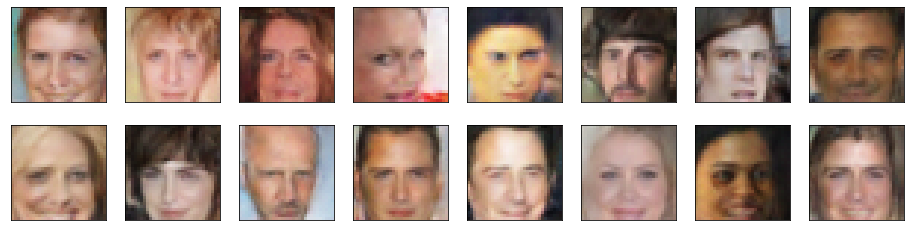

Epoch [   25/   50] | d_loss: 1.1308 | g_loss: 1.8450
Epoch [   25/   50] | d_loss: 0.8530 | g_loss: 1.5569
Epoch [   25/   50] | d_loss: 1.3685 | g_loss: 2.2127
Epoch [   25/   50] | d_loss: 0.6986 | g_loss: 2.0991
Epoch [   25/   50] | d_loss: 0.7434 | g_loss: 1.0659
Epoch [   25/   50] | d_loss: 0.8622 | g_loss: 2.7021
Epoch [   25/   50] | d_loss: 0.9266 | g_loss: 2.0625
Epoch [   25/   50] | d_loss: 0.8199 | g_loss: 1.6843
Epoch [   25/   50] | d_loss: 1.0858 | g_loss: 1.0759
Epoch [   25/   50] | d_loss: 1.0653 | g_loss: 2.3818
Epoch [   25/   50] | d_loss: 0.6477 | g_loss: 1.5226
Epoch [   25/   50] | d_loss: 0.9864 | g_loss: 2.1218
Epoch [   25/   50] | d_loss: 0.8563 | g_loss: 2.4678
Epoch [   25/   50] | d_loss: 1.0557 | g_loss: 1.5473
Epoch [   25/   50] | d_loss: 0.4443 | g_loss: 1.6691
Epoch [   25/   50] | d_loss: 0.6537 | g_loss: 1.6125
Epoch [   25/   50] | d_loss: 1.0002 | g_loss: 2.0496
Epoch [   25/   50] | d_loss: 0.9000 | g_loss: 2.1988
Epoch [   25/   50] | d_loss

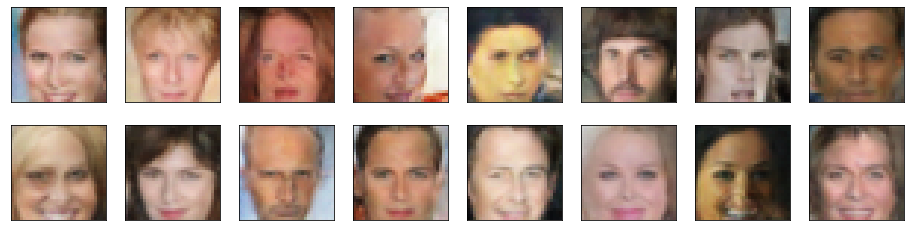

Epoch [   26/   50] | d_loss: 0.8558 | g_loss: 1.7784
Epoch [   26/   50] | d_loss: 1.1688 | g_loss: 0.9820
Epoch [   26/   50] | d_loss: 1.3480 | g_loss: 1.7469
Epoch [   26/   50] | d_loss: 0.6101 | g_loss: 1.8549
Epoch [   26/   50] | d_loss: 0.9283 | g_loss: 1.1669
Epoch [   26/   50] | d_loss: 0.9937 | g_loss: 2.1028
Epoch [   26/   50] | d_loss: 0.6397 | g_loss: 2.0879
Epoch [   26/   50] | d_loss: 0.6424 | g_loss: 1.8558
Epoch [   26/   50] | d_loss: 0.8612 | g_loss: 1.8036
Epoch [   26/   50] | d_loss: 0.7987 | g_loss: 2.9471
Epoch [   26/   50] | d_loss: 0.8828 | g_loss: 2.1882
Epoch [   26/   50] | d_loss: 0.7386 | g_loss: 1.7738
Epoch [   26/   50] | d_loss: 1.0433 | g_loss: 2.2721
Epoch [   26/   50] | d_loss: 0.9664 | g_loss: 1.4771
Epoch [   26/   50] | d_loss: 0.9275 | g_loss: 2.1651
Epoch [   26/   50] | d_loss: 0.6737 | g_loss: 2.4888
Epoch [   26/   50] | d_loss: 1.2204 | g_loss: 3.1293
Epoch [   26/   50] | d_loss: 0.9852 | g_loss: 1.9378
Epoch [   26/   50] | d_loss

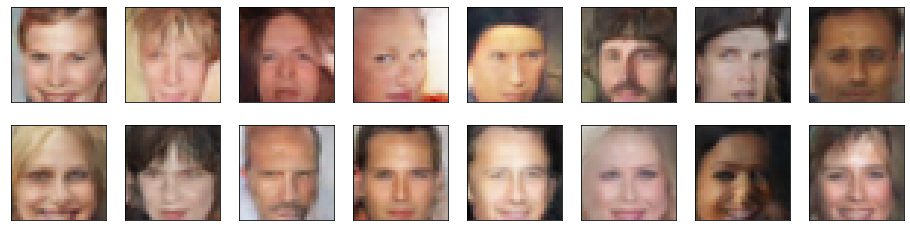

Epoch [   27/   50] | d_loss: 1.9192 | g_loss: 4.0791
Epoch [   27/   50] | d_loss: 0.7297 | g_loss: 2.5892
Epoch [   27/   50] | d_loss: 0.8490 | g_loss: 2.2901
Epoch [   27/   50] | d_loss: 1.1670 | g_loss: 2.3451
Epoch [   27/   50] | d_loss: 0.9178 | g_loss: 1.8371
Epoch [   27/   50] | d_loss: 1.1394 | g_loss: 1.3980
Epoch [   27/   50] | d_loss: 0.9772 | g_loss: 2.2092
Epoch [   27/   50] | d_loss: 0.6773 | g_loss: 2.4386
Epoch [   27/   50] | d_loss: 1.0296 | g_loss: 2.3328
Epoch [   27/   50] | d_loss: 0.8944 | g_loss: 1.2718
Epoch [   27/   50] | d_loss: 0.8676 | g_loss: 1.8508
Epoch [   27/   50] | d_loss: 1.0756 | g_loss: 2.0541
Epoch [   27/   50] | d_loss: 1.1686 | g_loss: 2.5085
Epoch [   27/   50] | d_loss: 0.8331 | g_loss: 1.3669
Epoch [   27/   50] | d_loss: 0.8273 | g_loss: 1.6202
Epoch [   27/   50] | d_loss: 1.0210 | g_loss: 1.6490
Epoch [   27/   50] | d_loss: 0.8478 | g_loss: 1.3110
Epoch [   27/   50] | d_loss: 0.8246 | g_loss: 2.0797
Epoch [   27/   50] | d_loss

Epoch [   28/   50] | d_loss: 1.1113 | g_loss: 2.0262
Epoch [   28/   50] | d_loss: 0.7539 | g_loss: 1.8624
Epoch [   28/   50] | d_loss: 0.4070 | g_loss: 1.8500
Epoch [   28/   50] | d_loss: 0.8746 | g_loss: 0.9197
Epoch [   28/   50] | d_loss: 0.9110 | g_loss: 1.4372
Epoch [   28/   50] | d_loss: 0.8138 | g_loss: 1.9473
Epoch [   28/   50] | d_loss: 0.5534 | g_loss: 1.8016
Epoch [   28/   50] | d_loss: 0.8037 | g_loss: 2.3802
Epoch [   28/   50] | d_loss: 0.7707 | g_loss: 1.9233
Epoch [   28/   50] | d_loss: 1.0379 | g_loss: 2.1885
Epoch [   28/   50] | d_loss: 0.8972 | g_loss: 3.7146
Epoch [   28/   50] | d_loss: 0.9488 | g_loss: 1.7129
Epoch [   28/   50] | d_loss: 1.1843 | g_loss: 1.9262
Epoch [   28/   50] | d_loss: 0.8864 | g_loss: 2.1492
Epoch [   28/   50] | d_loss: 0.7360 | g_loss: 2.3273
Epoch [   28/   50] | d_loss: 0.7554 | g_loss: 2.6639
Epoch [   28/   50] | d_loss: 0.8093 | g_loss: 3.1227
Epoch [   28/   50] | d_loss: 0.8118 | g_loss: 1.2824
Epoch [   28/   50] | d_loss

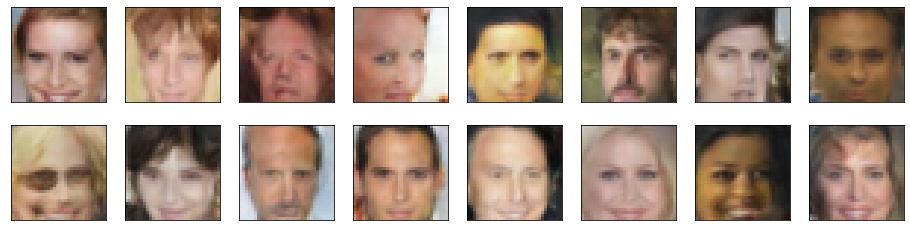

Epoch [   29/   50] | d_loss: 1.9402 | g_loss: 1.9404
Epoch [   29/   50] | d_loss: 0.6665 | g_loss: 1.8619
Epoch [   29/   50] | d_loss: 0.6334 | g_loss: 1.5877
Epoch [   29/   50] | d_loss: 0.8199 | g_loss: 1.8837
Epoch [   29/   50] | d_loss: 0.8409 | g_loss: 1.1499
Epoch [   29/   50] | d_loss: 1.0932 | g_loss: 2.1542
Epoch [   29/   50] | d_loss: 0.9912 | g_loss: 1.6271
Epoch [   29/   50] | d_loss: 0.7000 | g_loss: 1.2078
Epoch [   29/   50] | d_loss: 0.7803 | g_loss: 2.4263
Epoch [   29/   50] | d_loss: 0.7450 | g_loss: 2.3391
Epoch [   29/   50] | d_loss: 0.9340 | g_loss: 2.1482
Epoch [   29/   50] | d_loss: 0.8302 | g_loss: 2.1591
Epoch [   29/   50] | d_loss: 0.8778 | g_loss: 2.2916
Epoch [   29/   50] | d_loss: 1.2177 | g_loss: 3.0079
Epoch [   29/   50] | d_loss: 0.8378 | g_loss: 1.7995
Epoch [   29/   50] | d_loss: 0.9980 | g_loss: 1.0180
Epoch [   29/   50] | d_loss: 0.8653 | g_loss: 1.8294
Epoch [   29/   50] | d_loss: 0.8846 | g_loss: 1.5483
Epoch [   29/   50] | d_loss

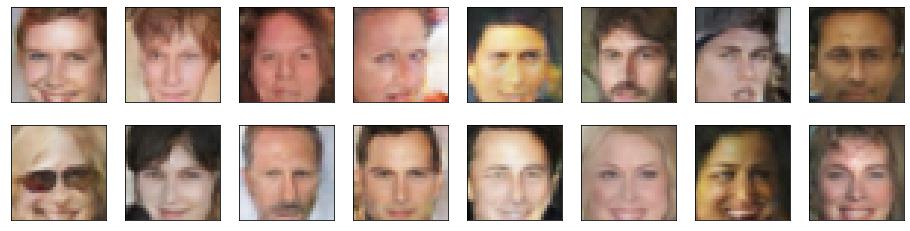

Epoch [   30/   50] | d_loss: 0.8337 | g_loss: 1.7202
Epoch [   30/   50] | d_loss: 0.8867 | g_loss: 2.2418
Epoch [   30/   50] | d_loss: 0.7236 | g_loss: 1.9281
Epoch [   30/   50] | d_loss: 1.1352 | g_loss: 1.3630
Epoch [   30/   50] | d_loss: 0.7254 | g_loss: 1.8565
Epoch [   30/   50] | d_loss: 0.9032 | g_loss: 2.9677
Epoch [   30/   50] | d_loss: 0.9689 | g_loss: 2.1830
Epoch [   30/   50] | d_loss: 0.6225 | g_loss: 1.5016
Epoch [   30/   50] | d_loss: 0.8617 | g_loss: 1.7516
Epoch [   30/   50] | d_loss: 1.0976 | g_loss: 1.7422
Epoch [   30/   50] | d_loss: 0.8402 | g_loss: 2.2494
Epoch [   30/   50] | d_loss: 0.8716 | g_loss: 2.6080
Epoch [   30/   50] | d_loss: 1.0048 | g_loss: 2.2999
Epoch [   30/   50] | d_loss: 0.8265 | g_loss: 2.1396
Epoch [   30/   50] | d_loss: 0.6836 | g_loss: 1.9509
Epoch [   30/   50] | d_loss: 0.9157 | g_loss: 2.0289
Epoch [   30/   50] | d_loss: 1.0959 | g_loss: 1.2247
Epoch [   30/   50] | d_loss: 0.6842 | g_loss: 2.0027
Epoch [   30/   50] | d_loss

Epoch [   31/   50] | d_loss: 1.0994 | g_loss: 1.8574
Epoch [   31/   50] | d_loss: 0.6729 | g_loss: 1.3388
Epoch [   31/   50] | d_loss: 0.8935 | g_loss: 1.9284
Epoch [   31/   50] | d_loss: 0.8449 | g_loss: 2.3426
Epoch [   31/   50] | d_loss: 1.2283 | g_loss: 2.0656
Epoch [   31/   50] | d_loss: 1.0500 | g_loss: 2.9739
Epoch [   31/   50] | d_loss: 0.8727 | g_loss: 2.1614
Epoch [   31/   50] | d_loss: 0.7092 | g_loss: 1.7605
Epoch [   31/   50] | d_loss: 0.7964 | g_loss: 2.5879
Epoch [   31/   50] | d_loss: 0.9549 | g_loss: 2.3382
Epoch [   31/   50] | d_loss: 0.8772 | g_loss: 1.1839
Epoch [   31/   50] | d_loss: 0.9053 | g_loss: 2.2332
Epoch [   31/   50] | d_loss: 0.9415 | g_loss: 2.0370
Epoch [   31/   50] | d_loss: 1.2444 | g_loss: 1.9478
Epoch [   31/   50] | d_loss: 0.9291 | g_loss: 2.1039
Epoch [   31/   50] | d_loss: 0.3538 | g_loss: 2.1156
Epoch [   31/   50] | d_loss: 0.8432 | g_loss: 1.6681
Epoch [   31/   50] | d_loss: 0.8920 | g_loss: 2.1410
Epoch [   31/   50] | d_loss

Epoch [   32/   50] | d_loss: 1.3331 | g_loss: 2.1729
Epoch [   32/   50] | d_loss: 0.8063 | g_loss: 1.9660
Epoch [   32/   50] | d_loss: 0.7014 | g_loss: 2.5487
Epoch [   32/   50] | d_loss: 0.8722 | g_loss: 2.9020
Epoch [   32/   50] | d_loss: 0.8693 | g_loss: 2.2390
Epoch [   32/   50] | d_loss: 0.8106 | g_loss: 1.8556
Epoch [   32/   50] | d_loss: 0.8848 | g_loss: 2.3941
Epoch [   32/   50] | d_loss: 1.3973 | g_loss: 3.1192
Epoch [   32/   50] | d_loss: 0.8816 | g_loss: 1.7639
Epoch [   32/   50] | d_loss: 1.0101 | g_loss: 2.0253
Epoch [   32/   50] | d_loss: 0.7807 | g_loss: 1.7501
Epoch [   32/   50] | d_loss: 0.8189 | g_loss: 1.4446
Epoch [   32/   50] | d_loss: 0.6088 | g_loss: 2.1783
Epoch [   32/   50] | d_loss: 1.3773 | g_loss: 1.9893
Epoch [   32/   50] | d_loss: 0.8917 | g_loss: 1.9622
Epoch [   32/   50] | d_loss: 1.0206 | g_loss: 2.6028
Epoch [   32/   50] | d_loss: 1.1585 | g_loss: 3.2018
Epoch [   32/   50] | d_loss: 0.4675 | g_loss: 1.2742
Epoch [   32/   50] | d_loss

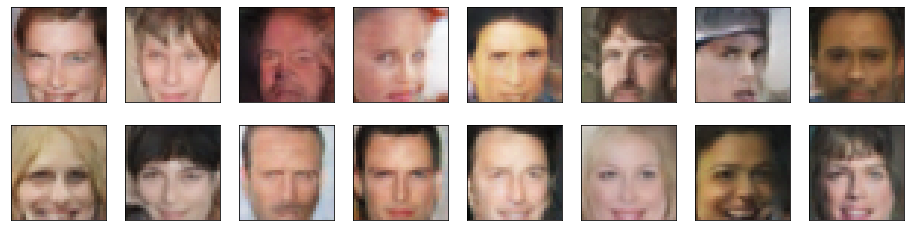

Epoch [   33/   50] | d_loss: 0.9566 | g_loss: 1.7427
Epoch [   33/   50] | d_loss: 0.8919 | g_loss: 1.5534
Epoch [   33/   50] | d_loss: 0.9616 | g_loss: 1.4805
Epoch [   33/   50] | d_loss: 0.8881 | g_loss: 1.7752
Epoch [   33/   50] | d_loss: 0.8660 | g_loss: 3.8222
Epoch [   33/   50] | d_loss: 0.6232 | g_loss: 2.0774
Epoch [   33/   50] | d_loss: 0.7622 | g_loss: 2.3374
Epoch [   33/   50] | d_loss: 0.6709 | g_loss: 1.3011
Epoch [   33/   50] | d_loss: 0.8471 | g_loss: 1.6690
Epoch [   33/   50] | d_loss: 1.0434 | g_loss: 2.3241
Epoch [   33/   50] | d_loss: 0.9485 | g_loss: 2.8374
Epoch [   33/   50] | d_loss: 1.0308 | g_loss: 2.5848
Epoch [   33/   50] | d_loss: 0.9063 | g_loss: 2.4690
Epoch [   33/   50] | d_loss: 0.9530 | g_loss: 1.1779
Epoch [   33/   50] | d_loss: 0.4711 | g_loss: 2.2182
Epoch [   33/   50] | d_loss: 1.0129 | g_loss: 2.5867
Epoch [   33/   50] | d_loss: 0.7423 | g_loss: 2.1372
Epoch [   33/   50] | d_loss: 0.5363 | g_loss: 1.9289
Epoch [   33/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.7518 | g_loss: 1.2419
Epoch [   34/   50] | d_loss: 1.2877 | g_loss: 2.0791
Epoch [   34/   50] | d_loss: 0.6159 | g_loss: 3.7312
Epoch [   34/   50] | d_loss: 0.9210 | g_loss: 1.7716
Epoch [   34/   50] | d_loss: 0.8794 | g_loss: 2.3730
Epoch [   34/   50] | d_loss: 0.7251 | g_loss: 1.9824
Epoch [   34/   50] | d_loss: 0.5813 | g_loss: 2.3552
Epoch [   34/   50] | d_loss: 0.8036 | g_loss: 2.7123
Epoch [   34/   50] | d_loss: 0.8834 | g_loss: 2.1503
Epoch [   34/   50] | d_loss: 1.0235 | g_loss: 2.3010
Epoch [   34/   50] | d_loss: 0.9318 | g_loss: 2.0226
Epoch [   34/   50] | d_loss: 0.9045 | g_loss: 1.4522
Epoch [   34/   50] | d_loss: 0.7436 | g_loss: 2.6691
Epoch [   34/   50] | d_loss: 0.7826 | g_loss: 2.2333
Epoch [   34/   50] | d_loss: 1.0855 | g_loss: 2.1724
Epoch [   34/   50] | d_loss: 0.8792 | g_loss: 1.6006
Epoch [   34/   50] | d_loss: 0.7203 | g_loss: 2.2508
Epoch [   34/   50] | d_loss: 0.7394 | g_loss: 2.0342
Epoch [   34/   50] | d_loss

Epoch [   35/   50] | d_loss: 1.4455 | g_loss: 2.0632
Epoch [   35/   50] | d_loss: 1.3539 | g_loss: 2.2610
Epoch [   35/   50] | d_loss: 0.6192 | g_loss: 1.5845
Epoch [   35/   50] | d_loss: 0.7243 | g_loss: 2.2289
Epoch [   35/   50] | d_loss: 0.9349 | g_loss: 1.7214
Epoch [   35/   50] | d_loss: 0.7101 | g_loss: 1.7570
Epoch [   35/   50] | d_loss: 0.8298 | g_loss: 1.3572
Epoch [   35/   50] | d_loss: 0.7428 | g_loss: 2.2087
Epoch [   35/   50] | d_loss: 0.9519 | g_loss: 2.2361
Epoch [   35/   50] | d_loss: 0.8875 | g_loss: 2.0002
Epoch [   35/   50] | d_loss: 0.9784 | g_loss: 2.5727
Epoch [   35/   50] | d_loss: 0.9916 | g_loss: 2.6050
Epoch [   35/   50] | d_loss: 0.8409 | g_loss: 1.7388
Epoch [   35/   50] | d_loss: 0.7587 | g_loss: 3.0678
Epoch [   35/   50] | d_loss: 0.8057 | g_loss: 1.3319
Epoch [   35/   50] | d_loss: 0.8440 | g_loss: 1.5989
Epoch [   35/   50] | d_loss: 0.9494 | g_loss: 2.4720
Epoch [   35/   50] | d_loss: 0.6242 | g_loss: 1.9533
Epoch [   35/   50] | d_loss

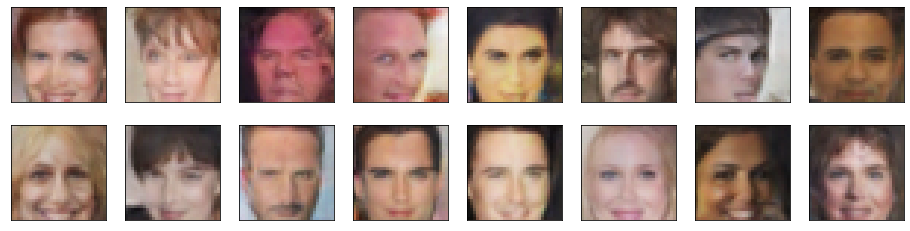

Epoch [   36/   50] | d_loss: 0.6266 | g_loss: 2.3610
Epoch [   36/   50] | d_loss: 1.4365 | g_loss: 1.6689
Epoch [   36/   50] | d_loss: 0.8022 | g_loss: 2.5659
Epoch [   36/   50] | d_loss: 0.8200 | g_loss: 1.3429
Epoch [   36/   50] | d_loss: 1.0084 | g_loss: 2.0016
Epoch [   36/   50] | d_loss: 0.5779 | g_loss: 2.7368
Epoch [   36/   50] | d_loss: 1.4209 | g_loss: 2.3954
Epoch [   36/   50] | d_loss: 0.9047 | g_loss: 3.1790
Epoch [   36/   50] | d_loss: 0.8450 | g_loss: 1.3531
Epoch [   36/   50] | d_loss: 0.5572 | g_loss: 2.8100
Epoch [   36/   50] | d_loss: 0.9883 | g_loss: 0.8520
Epoch [   36/   50] | d_loss: 0.6344 | g_loss: 2.2627
Epoch [   36/   50] | d_loss: 1.1713 | g_loss: 2.3582
Epoch [   36/   50] | d_loss: 0.7040 | g_loss: 1.9592
Epoch [   36/   50] | d_loss: 0.4852 | g_loss: 2.3894
Epoch [   36/   50] | d_loss: 0.9929 | g_loss: 2.4002
Epoch [   36/   50] | d_loss: 0.7947 | g_loss: 2.0375
Epoch [   36/   50] | d_loss: 0.8526 | g_loss: 1.4204
Epoch [   36/   50] | d_loss

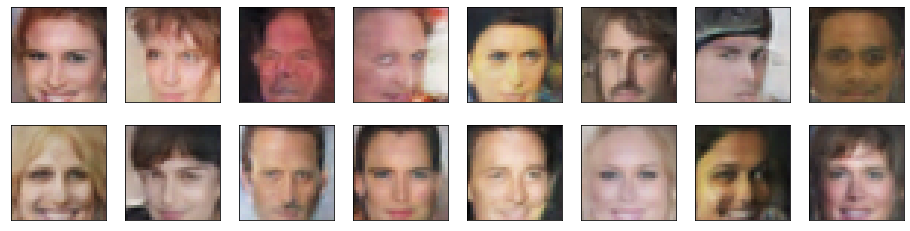

Epoch [   37/   50] | d_loss: 0.8449 | g_loss: 2.2095
Epoch [   37/   50] | d_loss: 0.9954 | g_loss: 2.4395
Epoch [   37/   50] | d_loss: 0.7532 | g_loss: 2.4759
Epoch [   37/   50] | d_loss: 0.8427 | g_loss: 2.8342
Epoch [   37/   50] | d_loss: 0.9415 | g_loss: 2.5394
Epoch [   37/   50] | d_loss: 0.5956 | g_loss: 2.6063
Epoch [   37/   50] | d_loss: 0.7996 | g_loss: 2.0571
Epoch [   37/   50] | d_loss: 0.5728 | g_loss: 1.4490
Epoch [   37/   50] | d_loss: 0.4331 | g_loss: 1.9909
Epoch [   37/   50] | d_loss: 0.9653 | g_loss: 1.6786
Epoch [   37/   50] | d_loss: 1.1696 | g_loss: 2.0331
Epoch [   37/   50] | d_loss: 0.9304 | g_loss: 2.1385
Epoch [   37/   50] | d_loss: 0.8610 | g_loss: 3.2277
Epoch [   37/   50] | d_loss: 0.7026 | g_loss: 1.7082
Epoch [   37/   50] | d_loss: 1.4675 | g_loss: 2.7137
Epoch [   37/   50] | d_loss: 0.5816 | g_loss: 2.8318
Epoch [   37/   50] | d_loss: 0.7181 | g_loss: 2.6923
Epoch [   37/   50] | d_loss: 0.9253 | g_loss: 2.8612
Epoch [   37/   50] | d_loss

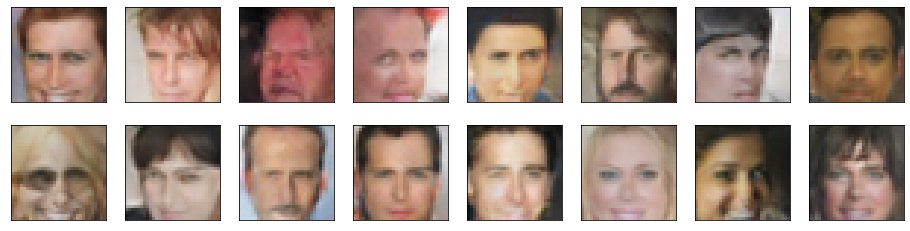

Epoch [   38/   50] | d_loss: 0.8919 | g_loss: 1.8737
Epoch [   38/   50] | d_loss: 0.7839 | g_loss: 3.0526
Epoch [   38/   50] | d_loss: 0.8941 | g_loss: 1.7481
Epoch [   38/   50] | d_loss: 0.7990 | g_loss: 2.4616
Epoch [   38/   50] | d_loss: 0.8257 | g_loss: 1.4294
Epoch [   38/   50] | d_loss: 0.9248 | g_loss: 2.7340
Epoch [   38/   50] | d_loss: 1.2744 | g_loss: 1.2133
Epoch [   38/   50] | d_loss: 1.7511 | g_loss: 1.3923
Epoch [   38/   50] | d_loss: 0.7434 | g_loss: 3.2465
Epoch [   38/   50] | d_loss: 0.8302 | g_loss: 2.3867
Epoch [   38/   50] | d_loss: 0.8476 | g_loss: 2.6591
Epoch [   38/   50] | d_loss: 0.5787 | g_loss: 2.6004
Epoch [   38/   50] | d_loss: 0.9672 | g_loss: 2.3160
Epoch [   38/   50] | d_loss: 0.7235 | g_loss: 2.3876
Epoch [   38/   50] | d_loss: 0.8718 | g_loss: 2.5285
Epoch [   38/   50] | d_loss: 1.0613 | g_loss: 3.2070
Epoch [   38/   50] | d_loss: 0.7574 | g_loss: 1.9210
Epoch [   38/   50] | d_loss: 1.4826 | g_loss: 2.0031
Epoch [   38/   50] | d_loss

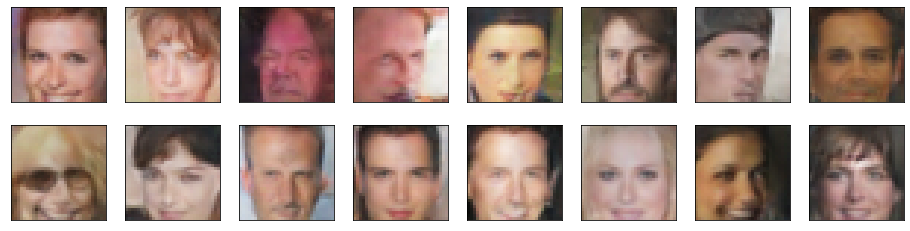

Epoch [   39/   50] | d_loss: 0.8157 | g_loss: 1.9868
Epoch [   39/   50] | d_loss: 0.9457 | g_loss: 2.2242
Epoch [   39/   50] | d_loss: 0.9498 | g_loss: 2.4984
Epoch [   39/   50] | d_loss: 0.5253 | g_loss: 1.8311
Epoch [   39/   50] | d_loss: 0.7945 | g_loss: 1.5337
Epoch [   39/   50] | d_loss: 0.7670 | g_loss: 1.2377
Epoch [   39/   50] | d_loss: 1.0030 | g_loss: 2.3646
Epoch [   39/   50] | d_loss: 0.8604 | g_loss: 1.6094
Epoch [   39/   50] | d_loss: 0.8154 | g_loss: 1.6324
Epoch [   39/   50] | d_loss: 0.8618 | g_loss: 2.7311
Epoch [   39/   50] | d_loss: 0.8932 | g_loss: 2.7450
Epoch [   39/   50] | d_loss: 0.8440 | g_loss: 4.1492
Epoch [   39/   50] | d_loss: 0.7772 | g_loss: 2.9010
Epoch [   39/   50] | d_loss: 0.6706 | g_loss: 2.4859
Epoch [   39/   50] | d_loss: 0.7300 | g_loss: 2.0138
Epoch [   39/   50] | d_loss: 1.0260 | g_loss: 1.9982
Epoch [   39/   50] | d_loss: 0.7270 | g_loss: 2.9720
Epoch [   39/   50] | d_loss: 0.9350 | g_loss: 1.7425
Epoch [   39/   50] | d_loss

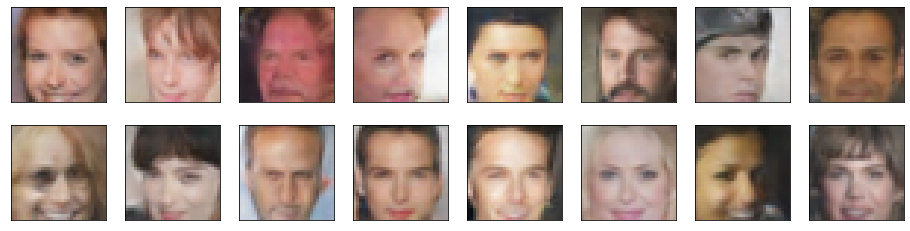

Epoch [   40/   50] | d_loss: 1.1415 | g_loss: 2.2610
Epoch [   40/   50] | d_loss: 0.5134 | g_loss: 2.2842
Epoch [   40/   50] | d_loss: 1.0146 | g_loss: 3.4280
Epoch [   40/   50] | d_loss: 0.8187 | g_loss: 2.6038
Epoch [   40/   50] | d_loss: 0.6750 | g_loss: 2.1990
Epoch [   40/   50] | d_loss: 1.0178 | g_loss: 2.7460
Epoch [   40/   50] | d_loss: 0.6160 | g_loss: 2.5122
Epoch [   40/   50] | d_loss: 0.9060 | g_loss: 1.8241
Epoch [   40/   50] | d_loss: 1.0894 | g_loss: 3.4550
Epoch [   40/   50] | d_loss: 0.6830 | g_loss: 1.9278
Epoch [   40/   50] | d_loss: 1.1097 | g_loss: 2.3252
Epoch [   40/   50] | d_loss: 0.7407 | g_loss: 2.0117
Epoch [   40/   50] | d_loss: 0.5498 | g_loss: 2.4610
Epoch [   40/   50] | d_loss: 0.7777 | g_loss: 2.8206
Epoch [   40/   50] | d_loss: 1.1377 | g_loss: 1.4586
Epoch [   40/   50] | d_loss: 0.7724 | g_loss: 4.0196
Epoch [   40/   50] | d_loss: 0.7619 | g_loss: 2.2082
Epoch [   40/   50] | d_loss: 0.7962 | g_loss: 1.8897
Epoch [   40/   50] | d_loss

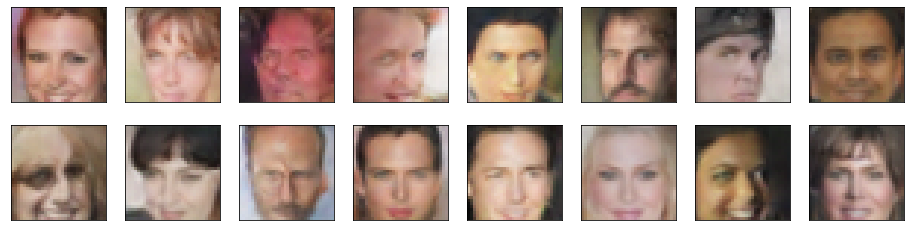

Epoch [   41/   50] | d_loss: 1.0916 | g_loss: 2.0821
Epoch [   41/   50] | d_loss: 0.5388 | g_loss: 1.9640
Epoch [   41/   50] | d_loss: 0.9781 | g_loss: 2.1320
Epoch [   41/   50] | d_loss: 0.7312 | g_loss: 3.5392
Epoch [   41/   50] | d_loss: 0.7530 | g_loss: 2.6498
Epoch [   41/   50] | d_loss: 0.9664 | g_loss: 2.0633
Epoch [   41/   50] | d_loss: 1.0143 | g_loss: 3.3571
Epoch [   41/   50] | d_loss: 0.4743 | g_loss: 2.1711
Epoch [   41/   50] | d_loss: 0.5753 | g_loss: 2.1213
Epoch [   41/   50] | d_loss: 0.7782 | g_loss: 2.4456
Epoch [   41/   50] | d_loss: 0.7264 | g_loss: 1.3931
Epoch [   41/   50] | d_loss: 0.9097 | g_loss: 2.9979
Epoch [   41/   50] | d_loss: 0.7855 | g_loss: 2.0356
Epoch [   41/   50] | d_loss: 0.9144 | g_loss: 1.4573
Epoch [   41/   50] | d_loss: 0.8871 | g_loss: 2.9290
Epoch [   41/   50] | d_loss: 0.6709 | g_loss: 2.8386
Epoch [   41/   50] | d_loss: 1.0081 | g_loss: 2.4123
Epoch [   41/   50] | d_loss: 0.6201 | g_loss: 2.4079
Epoch [   41/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.7120 | g_loss: 2.2295
Epoch [   42/   50] | d_loss: 0.8041 | g_loss: 2.8989
Epoch [   42/   50] | d_loss: 0.7228 | g_loss: 2.7045
Epoch [   42/   50] | d_loss: 1.2841 | g_loss: 2.6339
Epoch [   42/   50] | d_loss: 0.6683 | g_loss: 2.2378
Epoch [   42/   50] | d_loss: 0.9738 | g_loss: 1.8241
Epoch [   42/   50] | d_loss: 0.6960 | g_loss: 2.0475
Epoch [   42/   50] | d_loss: 0.7565 | g_loss: 2.0546
Epoch [   42/   50] | d_loss: 0.7637 | g_loss: 2.2546
Epoch [   42/   50] | d_loss: 0.5784 | g_loss: 2.1964
Epoch [   42/   50] | d_loss: 1.0919 | g_loss: 2.7008
Epoch [   42/   50] | d_loss: 0.4594 | g_loss: 2.4421
Epoch [   42/   50] | d_loss: 0.7788 | g_loss: 1.6890
Epoch [   42/   50] | d_loss: 0.6141 | g_loss: 1.7509
Epoch [   42/   50] | d_loss: 0.9377 | g_loss: 2.5349
Epoch [   42/   50] | d_loss: 0.6711 | g_loss: 3.0757
Epoch [   42/   50] | d_loss: 0.8964 | g_loss: 3.1797
Epoch [   42/   50] | d_loss: 0.6492 | g_loss: 2.8387
Epoch [   42/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.8713 | g_loss: 1.9068
Epoch [   43/   50] | d_loss: 0.8619 | g_loss: 1.7557
Epoch [   43/   50] | d_loss: 0.8494 | g_loss: 1.8893
Epoch [   43/   50] | d_loss: 0.6686 | g_loss: 1.9435
Epoch [   43/   50] | d_loss: 0.8394 | g_loss: 1.4487
Epoch [   43/   50] | d_loss: 0.8461 | g_loss: 4.1573
Epoch [   43/   50] | d_loss: 0.8843 | g_loss: 2.1975
Epoch [   43/   50] | d_loss: 1.0314 | g_loss: 2.5627
Epoch [   43/   50] | d_loss: 0.5272 | g_loss: 2.7918
Epoch [   43/   50] | d_loss: 0.8904 | g_loss: 1.8267
Epoch [   43/   50] | d_loss: 1.0646 | g_loss: 2.1457
Epoch [   43/   50] | d_loss: 0.7888 | g_loss: 1.6975
Epoch [   43/   50] | d_loss: 0.7698 | g_loss: 2.5027
Epoch [   43/   50] | d_loss: 0.8578 | g_loss: 2.7686
Epoch [   43/   50] | d_loss: 0.8255 | g_loss: 2.0081
Epoch [   43/   50] | d_loss: 1.3485 | g_loss: 2.9622
Epoch [   43/   50] | d_loss: 1.0942 | g_loss: 2.4730
Epoch [   43/   50] | d_loss: 0.4580 | g_loss: 2.4476
Epoch [   43/   50] | d_loss

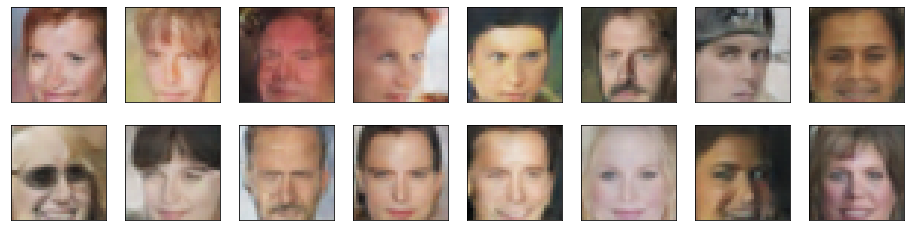

Epoch [   44/   50] | d_loss: 0.8307 | g_loss: 2.6835
Epoch [   44/   50] | d_loss: 0.9931 | g_loss: 3.3490
Epoch [   44/   50] | d_loss: 1.0473 | g_loss: 1.7773
Epoch [   44/   50] | d_loss: 1.3457 | g_loss: 1.8283
Epoch [   44/   50] | d_loss: 0.8826 | g_loss: 2.3060
Epoch [   44/   50] | d_loss: 0.7755 | g_loss: 3.0586
Epoch [   44/   50] | d_loss: 0.8268 | g_loss: 2.4712
Epoch [   44/   50] | d_loss: 0.8833 | g_loss: 2.2860
Epoch [   44/   50] | d_loss: 0.8251 | g_loss: 1.7432
Epoch [   44/   50] | d_loss: 0.5413 | g_loss: 2.1586
Epoch [   44/   50] | d_loss: 0.6285 | g_loss: 2.1216
Epoch [   44/   50] | d_loss: 1.0290 | g_loss: 2.9715
Epoch [   44/   50] | d_loss: 0.7689 | g_loss: 1.7398
Epoch [   44/   50] | d_loss: 0.6824 | g_loss: 3.5019
Epoch [   44/   50] | d_loss: 0.7665 | g_loss: 1.0876
Epoch [   44/   50] | d_loss: 0.7531 | g_loss: 1.9118
Epoch [   44/   50] | d_loss: 0.8604 | g_loss: 3.2214
Epoch [   44/   50] | d_loss: 0.9024 | g_loss: 2.2329
Epoch [   44/   50] | d_loss

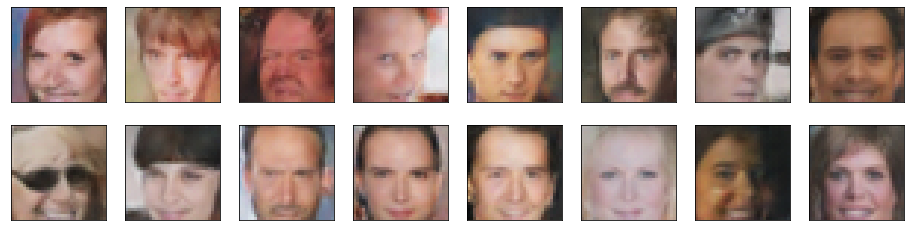

Epoch [   45/   50] | d_loss: 0.8412 | g_loss: 2.5175
Epoch [   45/   50] | d_loss: 1.1073 | g_loss: 2.3522
Epoch [   45/   50] | d_loss: 0.8530 | g_loss: 3.0044
Epoch [   45/   50] | d_loss: 1.0763 | g_loss: 2.7694
Epoch [   45/   50] | d_loss: 0.8217 | g_loss: 2.3216
Epoch [   45/   50] | d_loss: 0.6934 | g_loss: 2.1481
Epoch [   45/   50] | d_loss: 0.4238 | g_loss: 3.0572
Epoch [   45/   50] | d_loss: 0.5515 | g_loss: 2.7384
Epoch [   45/   50] | d_loss: 0.9799 | g_loss: 2.2585
Epoch [   45/   50] | d_loss: 1.0314 | g_loss: 1.8194
Epoch [   45/   50] | d_loss: 0.6435 | g_loss: 1.7324
Epoch [   45/   50] | d_loss: 0.9233 | g_loss: 3.5284
Epoch [   45/   50] | d_loss: 0.2845 | g_loss: 2.2910
Epoch [   45/   50] | d_loss: 0.6550 | g_loss: 1.8021
Epoch [   45/   50] | d_loss: 1.2194 | g_loss: 3.1400
Epoch [   45/   50] | d_loss: 0.8524 | g_loss: 1.3376
Epoch [   45/   50] | d_loss: 0.7695 | g_loss: 2.0034
Epoch [   45/   50] | d_loss: 0.5512 | g_loss: 2.4787
Epoch [   45/   50] | d_loss

Epoch [   46/   50] | d_loss: 1.2471 | g_loss: 2.7080
Epoch [   46/   50] | d_loss: 0.6424 | g_loss: 1.5145
Epoch [   46/   50] | d_loss: 0.7692 | g_loss: 3.9640
Epoch [   46/   50] | d_loss: 0.6320 | g_loss: 2.7525
Epoch [   46/   50] | d_loss: 0.6312 | g_loss: 2.8606
Epoch [   46/   50] | d_loss: 0.7184 | g_loss: 2.2457
Epoch [   46/   50] | d_loss: 0.8807 | g_loss: 1.8553
Epoch [   46/   50] | d_loss: 1.3023 | g_loss: 2.7078
Epoch [   46/   50] | d_loss: 1.1753 | g_loss: 2.0328
Epoch [   46/   50] | d_loss: 0.6099 | g_loss: 1.6791
Epoch [   46/   50] | d_loss: 0.9972 | g_loss: 1.7246
Epoch [   46/   50] | d_loss: 0.7103 | g_loss: 2.6254
Epoch [   46/   50] | d_loss: 0.9327 | g_loss: 2.0727
Epoch [   46/   50] | d_loss: 0.6618 | g_loss: 2.4245
Epoch [   46/   50] | d_loss: 0.7366 | g_loss: 3.1150
Epoch [   46/   50] | d_loss: 0.7480 | g_loss: 1.6834
Epoch [   46/   50] | d_loss: 0.9023 | g_loss: 1.8646
Epoch [   46/   50] | d_loss: 1.0846 | g_loss: 2.5904
Epoch [   46/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.8253 | g_loss: 2.2959
Epoch [   47/   50] | d_loss: 1.0563 | g_loss: 2.5223
Epoch [   47/   50] | d_loss: 0.8196 | g_loss: 2.7313
Epoch [   47/   50] | d_loss: 1.0619 | g_loss: 2.2279
Epoch [   47/   50] | d_loss: 1.6289 | g_loss: 2.5961
Epoch [   47/   50] | d_loss: 0.8813 | g_loss: 3.1626
Epoch [   47/   50] | d_loss: 1.0859 | g_loss: 2.3370
Epoch [   47/   50] | d_loss: 0.9039 | g_loss: 2.3069
Epoch [   47/   50] | d_loss: 1.0211 | g_loss: 2.3938
Epoch [   47/   50] | d_loss: 0.6606 | g_loss: 2.4020
Epoch [   47/   50] | d_loss: 0.7698 | g_loss: 2.1775
Epoch [   47/   50] | d_loss: 0.6447 | g_loss: 2.1024
Epoch [   47/   50] | d_loss: 0.9162 | g_loss: 2.3585
Epoch [   47/   50] | d_loss: 0.6290 | g_loss: 2.2639
Epoch [   47/   50] | d_loss: 0.7827 | g_loss: 3.0510
Epoch [   47/   50] | d_loss: 0.4917 | g_loss: 1.9708
Epoch [   47/   50] | d_loss: 1.1077 | g_loss: 1.7054
Epoch [   47/   50] | d_loss: 0.7108 | g_loss: 2.6126
Epoch [   47/   50] | d_loss

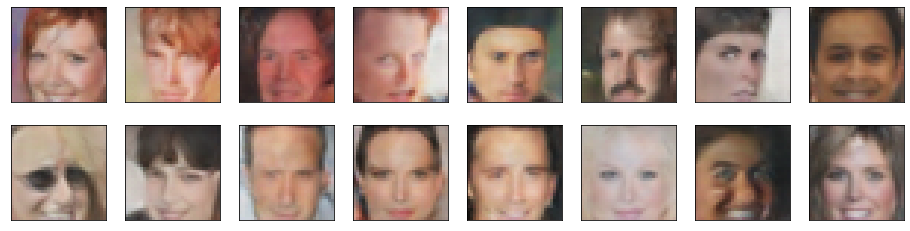

Epoch [   48/   50] | d_loss: 1.0174 | g_loss: 3.1153
Epoch [   48/   50] | d_loss: 0.7785 | g_loss: 2.6892
Epoch [   48/   50] | d_loss: 0.5703 | g_loss: 2.0482
Epoch [   48/   50] | d_loss: 0.7012 | g_loss: 2.2212
Epoch [   48/   50] | d_loss: 0.7859 | g_loss: 2.1775
Epoch [   48/   50] | d_loss: 0.9375 | g_loss: 3.0999
Epoch [   48/   50] | d_loss: 0.4792 | g_loss: 1.9640
Epoch [   48/   50] | d_loss: 0.6091 | g_loss: 2.6035
Epoch [   48/   50] | d_loss: 0.7850 | g_loss: 2.3338
Epoch [   48/   50] | d_loss: 0.9439 | g_loss: 3.0112
Epoch [   48/   50] | d_loss: 0.8643 | g_loss: 1.5109
Epoch [   48/   50] | d_loss: 0.8708 | g_loss: 2.1824
Epoch [   48/   50] | d_loss: 0.8383 | g_loss: 2.5850
Epoch [   48/   50] | d_loss: 0.7754 | g_loss: 1.9942
Epoch [   48/   50] | d_loss: 0.9123 | g_loss: 1.9706
Epoch [   48/   50] | d_loss: 0.6971 | g_loss: 2.3379
Epoch [   48/   50] | d_loss: 0.8495 | g_loss: 2.3289
Epoch [   48/   50] | d_loss: 0.8411 | g_loss: 2.2352
Epoch [   48/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.9131 | g_loss: 1.3715
Epoch [   49/   50] | d_loss: 0.6438 | g_loss: 1.6163
Epoch [   49/   50] | d_loss: 0.5253 | g_loss: 2.8516
Epoch [   49/   50] | d_loss: 0.7970 | g_loss: 2.9145
Epoch [   49/   50] | d_loss: 1.0741 | g_loss: 1.9062
Epoch [   49/   50] | d_loss: 0.7847 | g_loss: 3.0993
Epoch [   49/   50] | d_loss: 0.8700 | g_loss: 2.0762
Epoch [   49/   50] | d_loss: 0.5237 | g_loss: 1.6413
Epoch [   49/   50] | d_loss: 0.3665 | g_loss: 1.7735
Epoch [   49/   50] | d_loss: 0.9500 | g_loss: 2.2819
Epoch [   49/   50] | d_loss: 0.9227 | g_loss: 2.6255
Epoch [   49/   50] | d_loss: 0.7029 | g_loss: 2.0531
Epoch [   49/   50] | d_loss: 0.6214 | g_loss: 2.2611
Epoch [   49/   50] | d_loss: 0.6413 | g_loss: 1.7184
Epoch [   49/   50] | d_loss: 0.7208 | g_loss: 1.4087
Epoch [   49/   50] | d_loss: 0.6286 | g_loss: 3.0940
Epoch [   49/   50] | d_loss: 0.6384 | g_loss: 1.9785
Epoch [   49/   50] | d_loss: 0.6880 | g_loss: 2.8280
Epoch [   49/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.9992 | g_loss: 2.6753
Epoch [   50/   50] | d_loss: 0.9520 | g_loss: 2.7564
Epoch [   50/   50] | d_loss: 0.8173 | g_loss: 3.0415
Epoch [   50/   50] | d_loss: 0.9837 | g_loss: 1.7182
Epoch [   50/   50] | d_loss: 0.6555 | g_loss: 2.9574
Epoch [   50/   50] | d_loss: 0.6377 | g_loss: 1.5706
Epoch [   50/   50] | d_loss: 1.0104 | g_loss: 2.5621
Epoch [   50/   50] | d_loss: 0.9815 | g_loss: 1.6547
Epoch [   50/   50] | d_loss: 0.8578 | g_loss: 1.9695
Epoch [   50/   50] | d_loss: 0.6149 | g_loss: 2.1958
Epoch [   50/   50] | d_loss: 0.6906 | g_loss: 2.1353
Epoch [   50/   50] | d_loss: 0.6654 | g_loss: 3.1648
Epoch [   50/   50] | d_loss: 0.8036 | g_loss: 1.3782
Epoch [   50/   50] | d_loss: 0.5379 | g_loss: 2.8756
Epoch [   50/   50] | d_loss: 0.9928 | g_loss: 1.5583
Epoch [   50/   50] | d_loss: 0.6874 | g_loss: 1.2485
Epoch [   50/   50] | d_loss: 0.6748 | g_loss: 1.1680
Epoch [   50/   50] | d_loss: 0.5705 | g_loss: 1.9639
Epoch [   50/   50] | d_loss

In [22]:
# set number of epochs

n_epochs = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    fig.suptitle('Epoch {:3d}'.format(epoch+1), fontsize=14)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

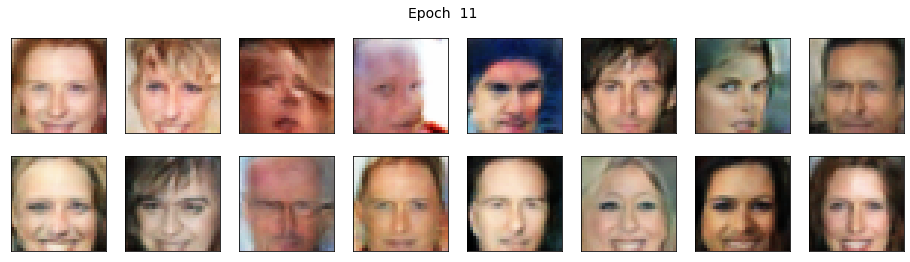

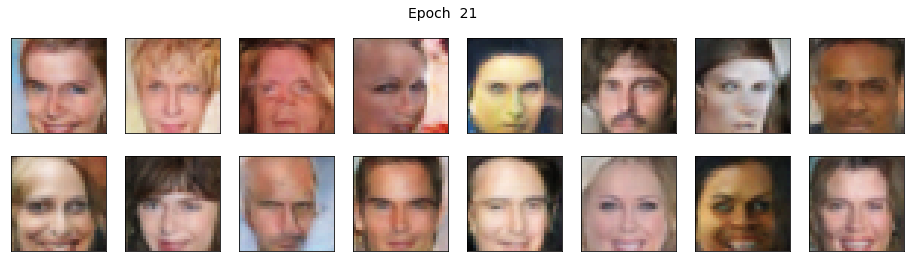

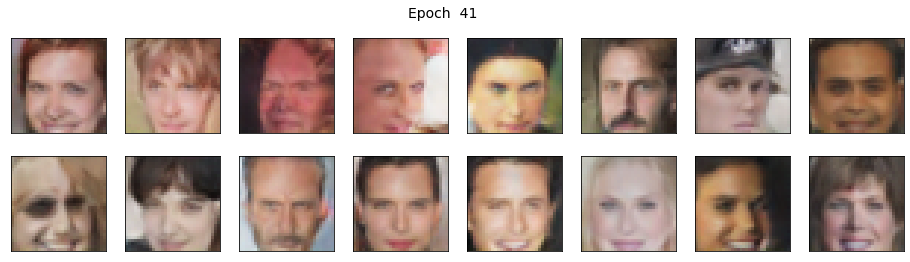

In [27]:
# show samples from every nth epoch

for i in range(0, n_epochs, 10):
    _ = view_samples(i, samples)
_ = view_samples(n_epochs-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

I started with hyperparameters that were typical in the other notebooks, as a reasonable default starting point:

* lr 0.0002, beta 0.5, 10 epochs
* faces were not entirely horrible, but the eyes were consistently too dark

Experiment halving learing rate and doubling training time:

* lr 0.0001, beta 0.5, 20 epochs
* results worsened, didn't like the output after any epochs, they looked like melted wax statues

Experiment changing Adam beta parameter:

* lr 0.0002, beta 0.9, 10 epochs
* training worsened considerably, outputs distorted, looked more pixelated

Experiment lowering Adam beta parameter:

* lr 0.0002, beta 0.2, 10 epochs
* training worsened as well but not as much


A beta 0.5 seemed to train the best.  
Output did not seem to improve much after 10 epochs.
Ideally I would increase image size to what computational resources can handle, for this project will leave it at 32.

Experiment turning on real_loss smoothing:

* made the results much worse. smooth appears best False for this application.

I would like to try training with larger images (64x64 perhaps) and increasing convolutional layers, within the computational resources available, to try and improve quality further.



**Resubmission 1**

As requested I got to work on improving the model further.

I read several papers and blogs on image generation, and got some pointers on best practices discovered so far, including this source: https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432


* LR 0.0002 and beta1 0.5 - suggested for best results so I left those set

* Added additional convolutional layer and increased conv_dim to 64

    * 4 convolutional layers from 64 to 512
    * 4 deconvolutional layers from 512 to 64

* Increased epochs to 30, then 50

* Added smoothing

    * added random smoothing for both fake and real labels - inspired by an award winning keras dog image generator
   
* Added dropout - experimented with two models simultaneously:

    * One model in Udacity workspace added Dropout after all convolutional layers
    
    * One model in Sagemaker workspace added Dropout after first and last convolutional layers only


**Subjective evaluation**

* Dropout on first and last layer only worked better

* The submitted faces have clearer faces, cheeks and eyes in particular, the shapes and proportions seem improved over my first submission.  Please let me know what you think.


**Further improvement**

* This model seems likely to benefit from additional epochs - when D and G loss stay close to 1 the model seems to keep improving.

* I would still like to try it with 64x64 images and a fifth convolutional layer of depth 1024.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.